# Step 0: Preparaton

## Install dependencies

In [1]:
!pip install -q flwr[simulation] flwr-datasets[vision] torch torchvision matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.1/65.1 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 31.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 478.6/478.6 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 6.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently ta

In [2]:
import json
import os
import re
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

from collections import OrderedDict
from typing import List, Tuple
import time
import os
from collections import Counter
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
import torchvision.transforms as transforms
from datasets.utils.logging import disable_progress_bar
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import flwr
from flwr.client import Client, ClientApp, NumPyClient
from flwr.common import Metrics, Context
from flwr.server import ServerApp, ServerConfig, ServerAppComponents
from flwr.server.strategy import FedAvg
from flwr.simulation import run_simulation
import seaborn as sns


from typing import Any, Dict, Optional, Tuple, Union,List

from datasets import Dataset, DatasetDict
from flwr_datasets.common import EventType, event
from flwr_datasets.preprocessor import Preprocessor
from flwr_datasets.utils import _instantiate_merger_if_needed, _instantiate_partitioners
from flwr_datasets.partitioner.partitioner import Partitioner
from typing import Union, Optional, List
from flwr_datasets.common.typing import NDArrayFloat

import datasets
from datasets import Dataset, DatasetDict
import torchvision.transforms as transforms
from collections import defaultdict

from torch.utils.data import DataLoader
from torchvision import models
from torchvision.models import MobileNet_V2_Weights

DEVICE = torch.device("cpu")
print(f"Flower {flwr.__version__} / PyTorch {torch.__version__}")
disable_progress_bar()

Flower 1.12.0 / PyTorch 2.4.1+cu121


#Step 1: Data Analysis

## Load Dataset

In [6]:
# Step 1: Load the CelebA dataset
dataset = datasets.load_dataset(path="flwrlabs/celeba")

# Function to calculate demographic label
def assign_demographic_label(row):
    """
    Assign a demographic label based on the 'Male' and 'Young' attributes in the dataset.

    Args:
        row (dict): A dictionary representing a single data entry with attributes 'Male' and 'Young'.
                    These attributes are expected to be boolean values.

    Returns:
        int: An integer representing the demographic label, where:
             0 -> "Not Male & Not Young"
             1 -> "Not Male & Young"
             2 -> "Male & Not Young"
             3 -> "Male & Young"
    """
    # Ensure 'Male' and 'Young' values are integers (0 or 1)
    male = int(row['Male'])
    young = int(row['Young'])
    return (male << 1) | young

# Apply the function to assign demographic labels
def add_demographic_labels(dataset):
    """
    Add a 'Demographic_Label' field to the dataset.

    Args:
    dataset (list of dict): The dataset where each row is a dictionary.

    Returns:
    list of dict: The dataset with added demographic labels.
    """
    return dataset.map(lambda x: {"Demographic_Label": assign_demographic_label(x)})

# Step 2: Add demographic labels
labeled_dataset = add_demographic_labels(dataset)

train-00008-of-00019.parquet:   0%|          | 0.00/497M [00:00<?, ?B/s]

train-00009-of-00019.parquet:   0%|          | 0.00/503M [00:00<?, ?B/s]

train-00010-of-00019.parquet:   0%|          | 0.00/498M [00:00<?, ?B/s]

train-00011-of-00019.parquet:   0%|          | 0.00/501M [00:00<?, ?B/s]

train-00012-of-00019.parquet:   0%|          | 0.00/494M [00:00<?, ?B/s]

train-00013-of-00019.parquet:   0%|          | 0.00/504M [00:00<?, ?B/s]

train-00014-of-00019.parquet:   0%|          | 0.00/490M [00:00<?, ?B/s]

train-00015-of-00019.parquet:   0%|          | 0.00/489M [00:00<?, ?B/s]

train-00016-of-00019.parquet:   0%|          | 0.00/498M [00:00<?, ?B/s]

train-00017-of-00019.parquet:   0%|          | 0.00/489M [00:00<?, ?B/s]

train-00018-of-00019.parquet:   0%|          | 0.00/489M [00:00<?, ?B/s]

valid-00000-of-00003.parquet:   0%|          | 0.00/388M [00:00<?, ?B/s]

valid-00001-of-00003.parquet:   0%|          | 0.00/385M [00:00<?, ?B/s]

valid-00002-of-00003.parquet:   0%|          | 0.00/384M [00:00<?, ?B/s]

test-00000-of-00003.parquet:   0%|          | 0.00/391M [00:00<?, ?B/s]

test-00001-of-00003.parquet:   0%|          | 0.00/384M [00:00<?, ?B/s]

test-00002-of-00003.parquet:   0%|          | 0.00/383M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[11167, 83342, 24815, 43446]


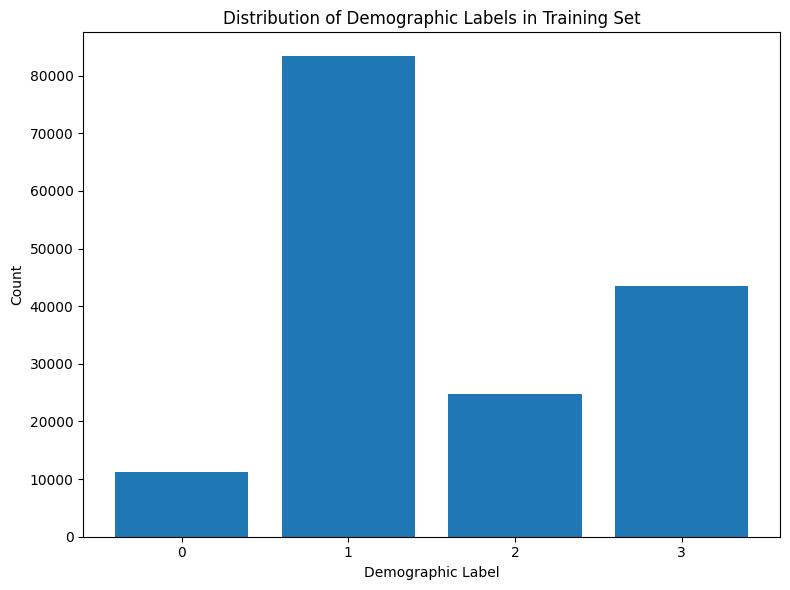

In [ ]:
# Count occurrences of each label using Counter
label_counts = Counter(labeled_dataset['train']['Demographic_Label'])

# Ensure all labels 0, 1, 2, 3 are present in the count
all_labels = [0, 1, 2, 3]
counts = [label_counts.get(label, 0) for label in all_labels]
print(counts)

# Plotting the distribution of demographic labels
plt.figure(figsize=(8, 6))
plt.bar(all_labels, counts)
plt.xlabel('Demographic Label')
plt.ylabel('Count')
plt.title('Distribution of Demographic Labels in Training Set')
plt.xticks(all_labels)
plt.tight_layout()
plt.show()

# Data Distribution

Build a dataset FedDataset for federated learning/evaluation/analytics

In [7]:
class FedDataset:
    """Representation of a dataset for federated learning/evaluation/analytics.

    Directly uses a pre-loaded DatasetDict object for federated operations.

    Parameters
    ----------
    dataset : DatasetDict
        The dataset already loaded in the form of a Hugging Face DatasetDict.
    preprocessor : Optional[Union[Preprocessor, Dict[str, Tuple[str, ...]]]]
        `Callable` that transforms `DatasetDict` by resplitting, removing
        features, creating new features, performing any other preprocessing operation,
        or configuration dict for `Merger`. Applied after shuffling. If None,
        no operation is applied.
    partitioners : Dict[str, Union[Partitioner, int]]
        A dictionary mapping the Dataset split (a `str`) to a `Partitioner` or an `int`
        (representing the number of IID partitions that this split should be
        partitioned into, i.e., using the default partitioner).
    shuffle : bool
        Whether to randomize the order of samples. Applied prior to preprocessing
        operations, separately to each of the present splits in the dataset.
        Defaults to True.
    seed : Optional[int]
        Seed used for dataset shuffling. It has no effect if `shuffle` is False.
        Defaults to 42.

    Examples
    --------
    Use a preloaded MNIST DatasetDict for federated learning with 100 clients:

    >>> from flwr_datasets import FederatedDataset
    >>>
    >>> fds = FederatedDataset(dataset=mnist_dataset, partitioners={"train": 100})
    >>> # Load partition for a client with ID 10.
    >>> partition = fds.load_partition(10)
    >>> # Use test split for centralized evaluation.
    >>> centralized = fds.load_split("test")
    """

    def __init__(
        self,
        *,
        dataset: DatasetDict,
        preprocessor: Optional[Union[Preprocessor, Dict[str, Tuple[str, ...]]]] = None,
        partitioners: Dict[str, Union[Partitioner, int]],
        shuffle: bool = True,
        seed: Optional[int] = 42,
    ) -> None:
        self._dataset: DatasetDict = dataset
        self._preprocessor: Optional[Preprocessor] = _instantiate_merger_if_needed(
            preprocessor
        )
        # If the dataset is not already a dictionary with splits as keys,
        # we assume it represents a single split, and we name it "train"
        if not hasattr(dataset, "keys"):  # Check if dataset has keys() method
            self._dataset = {"train": dataset}  # Wrap in a dictionary with "train" key
        else:
            self._dataset = dataset

        self._partitioners: Dict[str, Partitioner] = _instantiate_partitioners(
            partitioners
        )
        self._shuffle = shuffle
        self._seed = seed
        self._dataset_prepared: bool = False
        self._event = {
            "load_partition": {split: False for split in self._partitioners},
        }

    def load_partition(
        self,
        partition_id: int,
        split: Optional[str] = None,
    ) -> Dataset:
        """Load the partition specified by the idx in the selected split."""
        if not self._dataset_prepared:
            self._prepare_dataset()
        if split is None:
            self._check_if_no_split_keyword_possible()
            split = list(self._partitioners.keys())[0]
        self._check_if_split_present(split)
        self._check_if_split_possible_to_federate(split)
        partitioner: Partitioner = self._partitioners[split]
        self._assign_dataset_to_partitioner(split)
        partition = partitioner.load_partition(partition_id)
        if not self._event["load_partition"][split]:
            event(
                EventType.LOAD_PARTITION_CALLED,
                {
                    "federated_dataset_id": id(self),
                    "split": split,
                    "partitioner": partitioner.__class__.__name__,
                    "num_partitions": partitioner.num_partitions,
                },
            )
            self._event["load_partition"][split] = True
        return partition

    def load_split(self, split: str) -> Dataset:
        """Load the full split of the dataset."""
        if not self._dataset_prepared:
            self._prepare_dataset()
        self._check_if_split_present(split)
        dataset_split = self._dataset[split]
        return dataset_split

    def _check_if_split_present(self, split: str) -> None:
        """Check if the split is in the dataset."""
        available_splits = list(self._dataset.keys())
        if split not in available_splits:
            raise ValueError(
                f"The given split: '{split}' is not present in the dataset's splits: "
                f"'{available_splits}'."
            )

    def _check_if_split_possible_to_federate(self, split: str) -> None:
        """Check if the split has a corresponding partitioner."""
        partitioners_keys = list(self._partitioners.keys())
        if split not in partitioners_keys:
            raise ValueError(
                f"The given split: '{split}' does not have a partitioner to perform "
                f"partitioning. Partitioners were specified for the following splits:"
                f"'{partitioners_keys}'."
            )

    def _assign_dataset_to_partitioner(self, split: str) -> None:
        """Assign the corresponding split of the dataset to the partitioner."""
        if not self._partitioners[split].is_dataset_assigned():
            self._partitioners[split].dataset = self._dataset[split]

    def _prepare_dataset(self) -> None:
        """Prepare the dataset (prior to partitioning) by shuffle and preprocess."""
        if self._shuffle:
            self._dataset = self._dataset.shuffle(seed=self._seed)
        if self._preprocessor:
            self._dataset = self._preprocessor(self._dataset)
        self._dataset_prepared = True

    def _check_if_no_split_keyword_possible(self) -> None:
        if len(self._partitioners) != 1:
            raise ValueError(
                "Please set the `split` argument. You can only omit the split keyword "
                "if there is exactly one partitioner specified."
            )

Load and partition the CelebA dataset for federated learning

In [ ]:
def load_datasets(partition_id: int, num_partitions: int, batch_size:int, non_iid=False) -> tuple:
    """
    Load and partition the CelebA dataset for federated learning.

    Args:
        partition_id (int): The ID of the partition to load for the specific client.
        num_partitions (int): The total number of partitions to divide the dataset into.
        batch_size (int): The batch size for the DataLoader objects.
        non_iid (bool): Whether to use a non-IID partition

    Returns:
        tuple: A tuple containing three DataLoader objects:
            - trainloader: DataLoader for the training data of the specified partition.
            - valloader: DataLoader for the validation data (20% of the partition's data).
            - testloader: DataLoader for the global test set.

    Steps:
    1. Load the CelebA dataset using the `datasets` library.
    2. Add demographic labels to the dataset using the `add_demographic_labels` function.
    3. Partition the dataset into `num_partitions` using a Visual Dirichlet Partitioner based on demographic labels.
    4. Load the specified partition (identified by `partition_id`) and split it into 80% training and 20% validation data.
    5. Apply PyTorch transforms (e.g., normalization) to the images in the dataset.
    6. Create PyTorch DataLoaders for the training, validation, and global test sets.

    :param num_partitions:
    :param partition_id:
    :param batch_size:
    :param non_iid:
    """
    # Step 1: Load the CelebA dataset
    dataset = datasets.load_dataset(path="flwrlabs/celeba")

    # Step 2: Add demographic labels
    labeled_dataset = add_demographic_labels(dataset)

    # Step 3: Select partitioning strategy
    if not non_iid:
        partitioner = IidPartitioner(num_partitions=num_partitions, partition_by="Demographic_Label")
    else:
        partitioner = VisualDirichletPartitioner(
            num_partitions=num_partitions,
            partition_by="Demographic_Label",
            alpha=0.5,
            min_partition_size=10
        )

    # Step 4: Partition the dataset and load the specified partition
    fds = FedDataset(dataset=labeled_dataset, partitioners={"train": partitioner})
    partition = fds.load_partition(partition_id)

    # Split partition into 80% training and 20% validation
    partition_train_test = partition.train_test_split(test_size=0.2, seed=42)

    # Define PyTorch transformations
    pytorch_transforms =  transforms.Compose([
        transforms.Resize((224, 224)),  # Resize the image to match the model's input size
        transforms.ToTensor(),  # Convert the image to a PyTorch tensor
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],  # Normalize the image using the mean and std of ImageNet
            std=[0.229, 0.224, 0.225]
        ),
    ])

    # Apply transformations to the dataset
    def apply_transforms(batch):
        batch["image"] = [pytorch_transforms(img) for img in batch["image"]]
        return batch

    partition_train_test = partition_train_test.with_transform(apply_transforms)

    # Step 5: Create DataLoaders for training, validation, and testing
    trainloader = DataLoader(partition_train_test["train"], batch_size=batch_size, shuffle=True)
    valloader = DataLoader(partition_train_test["test"], batch_size=batch_size)

    # Load global test set and apply transformations
    testset = fds.load_split("test").with_transform(apply_transforms)
    testloader = DataLoader(testset, batch_size=batch_size)

    return trainloader, valloader, testloader


### IID

Build a IID Partitioner to ensure each shard of client has the same size and the same class distribution as the original dataset.


In [ ]:
class IidPartitioner(Partitioner):
    """
    IID Partitioner with stratification to ensure each shard of the client has the same size
    and the same class distribution as the original dataset.

    Parameters
    ----------
    num_partitions : int
        The number of partitions to create.
    partition_by : str
        The name of the column containing class labels.
    """

    def __init__(self, num_partitions: int, partition_by: str) -> None:
        super().__init__()
        if num_partitions <= 0:
            raise ValueError("The number of partitions must be greater than zero.")
        self._num_partitions = num_partitions
        self.partition_by = partition_by
        self.partitions: Optional[List[List[int]]] = None  # Will hold partition indices

    def _create_partitions(self) -> List[List[int]]:
        """Create stratified partitions based on class labels."""
        if self._dataset is None:
            raise AttributeError("The dataset must be assigned before creating partitions.")

        # Group indices by class
        label_to_indices = defaultdict(list)
        for idx, example in enumerate(self._dataset):
            label_to_indices[example[self.partition_by]].append(idx)

        # Shuffle indices within each class
        for label, indices in label_to_indices.items():
            np.random.shuffle(indices)

        # Distribute indices evenly across partitions
        partitions = [[] for _ in range(self._num_partitions)]
        for label, indices in label_to_indices.items():
            num_samples = len(indices)
            shard_size = num_samples // self._num_partitions
            remainder = num_samples % self._num_partitions

            start_idx = 0
            for i in range(self._num_partitions):
                end_idx = start_idx + shard_size + (1 if i < remainder else 0)
                partitions[i].extend(indices[start_idx:end_idx])
                start_idx = end_idx

        # Shuffle partitions to mix classes randomly
        for partition in partitions:
            np.random.shuffle(partition)

        return partitions

    def load_partition(self, partition_id: int) -> Dataset:
        """
        Load a specific partition by ID.

        Parameters
        ----------
        partition_id : int
            The partition ID to load.

        Returns
        -------
        datasets.Dataset
            The dataset partition corresponding to the given partition ID.
        """
        if not self.is_dataset_assigned():
            raise AttributeError("The dataset must be assigned before loading partitions.")
        if not (0 <= partition_id < self._num_partitions):
            raise ValueError(f"Partition ID must be between 0 and {self._num_partitions - 1}.")

        # Create partitions if not already created
        if self.partitions is None:
            self.partitions = self._create_partitions()

        indices = self.partitions[partition_id]
        return self._dataset.select(indices)

    @property
    def num_partitions(self) -> int:
        """Total number of partitions."""
        return self._num_partitions

In [ ]:
partitioner = IidPartitioner(num_partitions=50, partition_by="Demographic_Label")
fds = FedDataset(dataset=labeled_dataset, partitioners={"train": partitioner})

client_data = []

for partition_id in range(50):  # Assuming there are 50 partitions
    partition = fds.load_partition(partition_id)

    # Count demographic labels
    demographic_counts = Counter(sample['Demographic_Label'] for sample in partition)
    client_data.append(demographic_counts)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


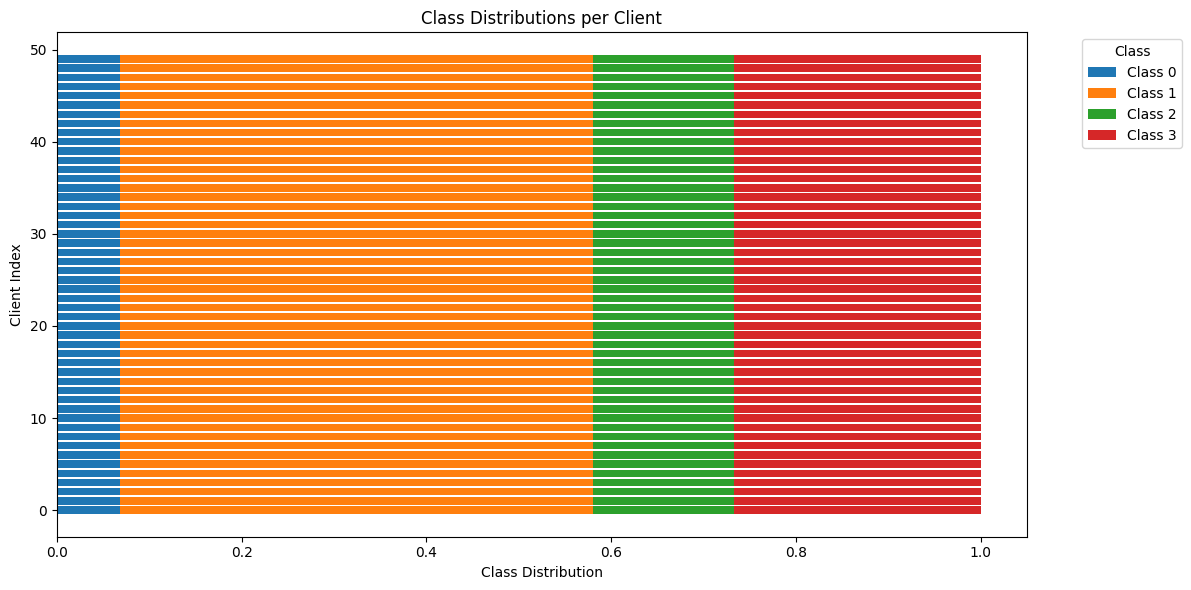

In [ ]:
# Convert to DataFrame for easier manipulation
df = pd.DataFrame(client_data).fillna(0)  # Replace NaN with 0 for missing classes
df.index.name = "Client"
df.columns.name = "Class"

# Ensure the columns are sorted in order (Class 0, Class 1, Class 2, Class 3)
df = df[sorted(df.columns, key=lambda x: int(x))]

# Normalize counts to get distributions
normalized_df = df.div(df.sum(axis=1), axis=0)

# Step 2: Plot the distribution with distinct colors
fig, ax = plt.subplots(figsize=(12, 6))

# Define distinct colors for each class
class_colors = {
    'Class 0': '#1f77b4',  # Blue
    'Class 1': '#ff7f0e',  # Orange
    'Class 2': '#2ca02c',  # Green
    'Class 3': '#d62728'   # Red
}

# Initialize bottom for stacking
bottom = np.zeros(len(normalized_df))

# Plot each class distribution with distinct colors
for cls in normalized_df.columns:
    ax.barh(normalized_df.index, normalized_df[cls], left=bottom, color=class_colors.get(f'Class {cls}', '#000000'), label=f'Class {cls}')
    bottom += normalized_df[cls]

# Add labels and legend
ax.set_xlabel("Class Distribution")
ax.set_ylabel("Client Index")
ax.set_title("Class Distributions per Client")
ax.legend(title="Class", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

### Non-IID

The implementation of the non-IID partitioner is based on the method described in:

> Measuring the effects of non-identical data distribution for federated visual classification.arXiv preprint arXiv:1909.06335 (2019).

The class distribution for each client is represented by a vector q, where qi denotes the probability of class i and the sum of all qi equals 1. To generate the client-specific class distribution vectors q, the authors sample from a Dirichlet distribution parameterized
by αlpha * p, where: p is a prior distribution over classes, reflecting the overall class distribution in the dataset. alpha is a concentration parameter that controls the similarity between the client distributions and the prior distribution p.

A higher alpha value results in client distributions q that are more similar to the prior distribution p,
indicating more homogeneous data across clients. A lower alpha value leads to client distributions that
are more skewed, with clients having data concentrated in fewer classes, thus increasing heterogeneity.


In [8]:
class VisualDirichletPartitioner(Partitioner):
    """Partitioner based on Dirichlet distribution for visual classifcation

    Implementation based on Measuring the effects of non-identical data distribution
    for federated visual classification.arXiv preprint arXiv:1909.06335 (2019).

    The class distribution for each client is represented by a vector q, where qi denotes
    the probability of class i and the sum of all qi equals 1. To generate the client-specific
    class distribution vectors q, the authors sample from a Dirichlet distribution parameterized
    by αlpha * p, where: p is a prior distribution over classes, reflecting the overall class
    distribution in the dataset. alpha is a concentration parameter that controls the similarity
    between the client distributions and the prior distribution p.


    A higher alpha value results in client distributions q that are more similar to the prior distribution p,
    indicating more homogeneous data across clients. A lower alpha value leads to client distributions that
    are more skewed, with clients having data concentrated in fewer classes, thus increasing heterogeneity.


    Parameters
    ----------
    num_partitions : int
        The total number of partitions that the data will be divided into.
    partition_by : str
        Column name of the labels (targets) based on which Dirichlet sampling works.
    alpha : Union[int, float, List[float]]
        Concentration parameter to the Dirichlet distribution
    min_partition_size : int
        The minimum number of samples that each partitions will have (the sampling
        process is repeated if any partition is too small).
    shuffle: bool
        Whether to randomize the order of samples. Shuffling applied after the
        samples assignment to partitions.
    seed: int
        Seed used for dataset shuffling. It has no effect if `shuffle` is False.
    """

    def __init__(
        self,
        num_partitions: int,
        partition_by: str,
        alpha: Union[int, float, list[float]],
        min_partition_size: int = 10,
        shuffle: bool = True,
        seed: Optional[int] = 42,
    ) -> None:
        super().__init__()
        # Attributes based on the constructor
        self._num_partitions = num_partitions
        self._check_num_partitions_greater_than_zero()
        self._alpha = self._initialize_alpha(alpha)
        self._partition_by = partition_by
        self._min_partition_size:int = min_partition_size
        self._shuffle = shuffle
        self._seed = seed
        self._rng = np.random.default_rng(seed=self._seed)

        # Utility attributes
        self._avg_num_of_samples_per_partition: Optional[float] = None
        self._unique_classes: Optional[Union[list[int], list[str]]] = None
        self._partition_id_to_indices: dict[int, list[int]] = {}
        self._partition_id_to_indices_determined = False

        # Attributes to store partitions
        self.partitions = None
        self.partition_determined = False


    def _initialize_alpha(
        self, alpha: Union[int, float, list[float], NDArrayFloat]
    ) -> NDArrayFloat:
        """Convert alpha to the used format in the code a NDArrayFloat.

        The alpha can be provided in constructor can be in different format for user
        convenience. The format into which it's transformed here is used throughout the
        code for computation.

        Parameters
        ----------
            alpha : Union[int, float, List[float], NDArrayFloat]
                Concentration parameter to the Dirichlet distribution

        Returns
        -------
        alpha : NDArrayFloat
            Concentration parameter in a format ready to used in computation.
        """
        if isinstance(alpha, int):
            alpha = np.array([float(alpha)], dtype=float).repeat(self._num_partitions)
        elif isinstance(alpha, float):
            alpha = np.array([alpha], dtype=float).repeat(self._num_partitions)
        elif isinstance(alpha, list):
            if len(alpha) != self._num_partitions:
                raise ValueError(
                    "If passing alpha as a List, it needs to be of length of equal to "
                    "num_partitions."
                )
            alpha = np.asarray(alpha)
        elif isinstance(alpha, np.ndarray):
            if alpha.ndim == 1 and alpha.shape[0] != self._num_partitions:
                raise ValueError(
                    "If passing alpha as an NDArray, its length needs to be of length "
                    "equal to num_partitions."
                )
            elif alpha.ndim == 2:
                alpha = alpha.flatten()
                if alpha.shape[0] != self._num_partitions:
                    raise ValueError(
                        "If passing alpha as an NDArray, its size needs to be of length"
                        " equal to num_partitions."
                    )
        else:
            raise ValueError("The given alpha format is not supported.")
        if not (alpha > 0).all():
            raise ValueError(
                f"Alpha values should be strictly greater than zero. "
                f"Instead it'd be converted to {alpha}"
            )
        return alpha

    def _determine_partition_id_to_indices_if_needed(
        self,
    ) -> None:
        """Create an assignment of indices to the partition indices."""
        if self._partition_id_to_indices_determined:
            return

        # Generate information needed for Dirichlet partitioning
        self._unique_classes = self.dataset.unique(self._partition_by)
        assert self._unique_classes is not None
        # This is needed only if self._self_balancing is True (the default option)
        self._avg_num_of_samples_per_partition = (
            self.dataset.num_rows / self._num_partitions
        )

        # Change targets list data type to numpy
        targets = np.array(self.dataset[self._partition_by])

        # Repeat the sampling procedure based on the Dirichlet distribution until the
        # min_partition_size is reached.
        sampling_try = 0
        while True:
            # Prepare data structure to store indices assigned to partition ids
            partition_id_to_indices: dict[int, list[int]] = {nid: [] for nid in range(self._num_partitions)}
            # Perform Dirichlet-based partitioning
            for class_label in self._unique_classes:
                # Access all the indices associated with class_label
                class_indices = np.nonzero(targets == class_label)[0]
                class_count = len(class_indices)

                # Determine proportions using Dirichlet distribution
                dirichlet_proportions = self._rng.dirichlet(self._alpha)
                # Normalize proportions to ensure minimum partition size
                normalized_proportions = np.clip(
                    dirichlet_proportions * class_count,
                    self._min_partition_size,
                    None
                ).astype(int)

                # Adjust proportions to maintain total sample count
                total_assigned = normalized_proportions.sum()
                if total_assigned < class_count:
                    normalized_proportions[np.argmax(dirichlet_proportions)] += class_count - total_assigned

                # Split class indices based on proportions
                cumulative_splits = np.cumsum(normalized_proportions)[:-1]
                split_indices = np.split(class_indices, cumulative_splits)

                # Assign indices to partitions
                for nid, indices in enumerate(split_indices):
                    partition_id_to_indices[nid].extend(indices)

            # Verify minimum partition size constraint
            min_sample_size_on_client = min(
                len(indices) for indices in partition_id_to_indices.values()
            )
            if min_sample_size_on_client >= self._min_partition_size:
                break

            sampling_try += 1
            if sampling_try >= 10:
                raise ValueError(
                    "Failed to generate partitions meeting the minimum size requirement "
                    "after 10 attempts. Adjust alpha or min_partition_size."
                )

        # Shuffle indices within each partition if required
        if self._shuffle:
            for indices in partition_id_to_indices.values():
                # In place shuffling
                self._rng.shuffle(indices)

        # Store the partition indices
        self._partition_id_to_indices = partition_id_to_indices
        self._partition_id_to_indices_determined = True


    def load_partition(self, partition_id: int) -> datasets.Dataset:
        """Load a single partition based on the partition index."""
        self._check_num_partitions_correctness_if_needed()
        self._determine_partition_id_to_indices_if_needed()
        return self.dataset.select(self._partition_id_to_indices[partition_id])

    @property
    def num_partitions(self) -> int:
        """Total number of partitions."""
        self._check_num_partitions_correctness_if_needed()
        self._determine_partition_id_to_indices_if_needed()
        return self._num_partitions


    def _check_num_partitions_correctness_if_needed(self) -> None:
        """Test num_partitions when the dataset is given (in load_partition)."""
        if not self._partition_id_to_indices_determined:
            if self._num_partitions > self.dataset.num_rows:
                raise ValueError(
                    "The number of partitions needs to be smaller than the number of "
                    "samples in the dataset."
                )

    def _check_num_partitions_greater_than_zero(self) -> None:
        """Test num_partition left sides correctness."""
        if not self._num_partitions > 0:
            raise ValueError("The number of partitions needs to be greater than zero.")

In [ ]:
partitioner = VisualDirichletPartitioner(
            num_partitions=50,
            partition_by="Demographic_Label",
            alpha=0.5,
            min_partition_size=10
        )

fds = FedDataset(dataset=labeled_dataset, partitioners={"train": partitioner})

client_data = []

for partition_id in range(50):  # Assuming there are 50 partitions
    partition = fds.load_partition(partition_id)

    # Count demographic labels
    demographic_counts = Counter(sample['Demographic_Label'] for sample in partition)
    # Save to client data
    client_data.append(demographic_counts)

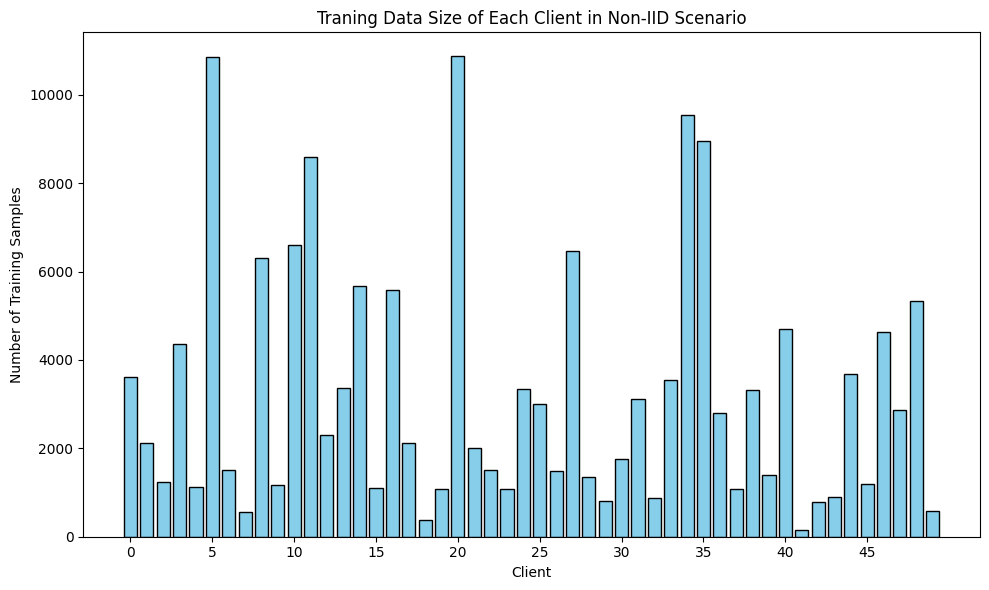

In [ ]:
# Step 1: Calculate total data size for each client
client_sizes = [sum(demographic_counts.values()) for demographic_counts in client_data]

# Step 2: Create a DataFrame for easier manipulation
client_df = pd.DataFrame({'Client': range(len(client_sizes)), 'Size': client_sizes})

# Step 3: Plot the data sizes for each client
plt.figure(figsize=(10, 6))
plt.bar(client_df['Client'], client_df['Size'], color='skyblue', edgecolor='black')

# Add labels and title
plt.xlabel("Client")
plt.ylabel("Number of Training Samples")
plt.title("Traning Data Size of Each Client in Non-IID Scenario")
plt.xticks(ticks=range(0, len(client_sizes), 5))  # Adjust tick frequency for better readability

# Show the plot
plt.tight_layout()
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


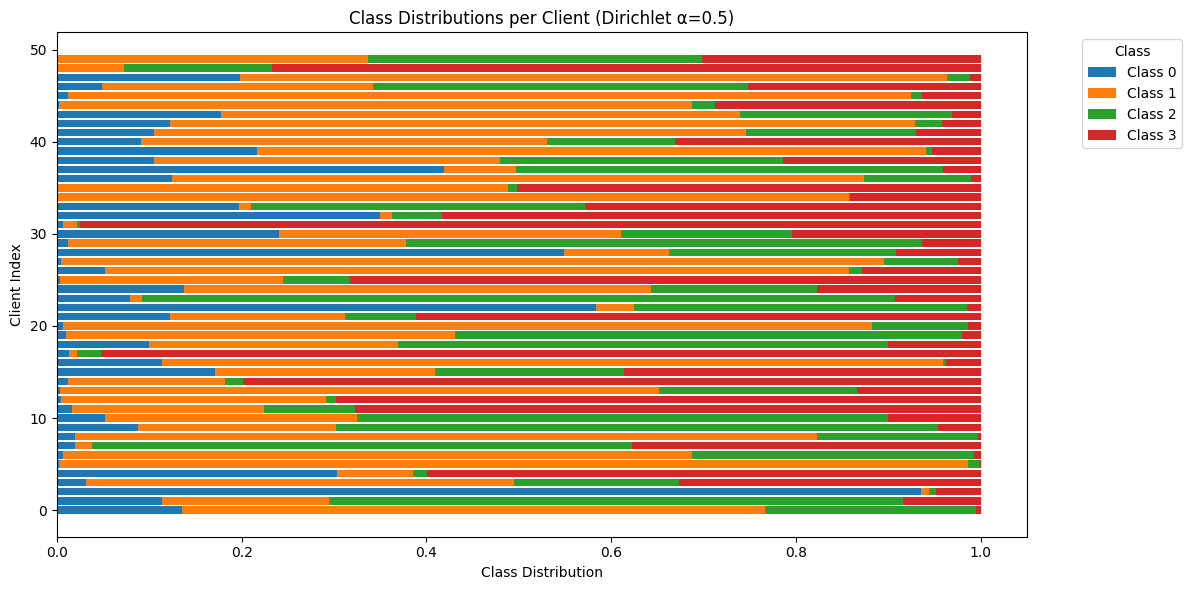

In [ ]:
# Convert to DataFrame for easier manipulation
df = pd.DataFrame(client_data).fillna(0)  # Replace NaN with 0 for missing classes
df.index.name = "Client"
df.columns.name = "Class"

# Ensure the columns are sorted in order (Class 0, Class 1, Class 2, Class 3)
df = df[sorted(df.columns, key=lambda x: int(x))]

# Normalize counts to get distributions
normalized_df = df.div(df.sum(axis=1), axis=0)

# Step 2: Plot the distribution with distinct colors
fig, ax = plt.subplots(figsize=(12, 6))

# Define distinct colors for each class
class_colors = {
    'Class 0': '#1f77b4',  # Blue
    'Class 1': '#ff7f0e',  # Orange
    'Class 2': '#2ca02c',  # Green
    'Class 3': '#d62728'   # Red
}

# Initialize bottom for stacking
bottom = np.zeros(len(normalized_df))

# Plot each class distribution with distinct colors
for cls in normalized_df.columns:
    ax.barh(normalized_df.index, normalized_df[cls], left=bottom, color=class_colors.get(f'Class {cls}', '#000000'), label=f'Class {cls}')
    bottom += normalized_df[cls]

# Add labels and legend
ax.set_xlabel("Class Distribution")
ax.set_ylabel("Client Index")
ax.set_title("Class Distributions per Client (Dirichlet \u03B1=0.5)")
ax.legend(title="Class", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

# Simulation

### Change part

In the default setting of FedAvg in FLower, the evaluate function are not well defined, I have modified it to achieve the evaluation on the server side using test dataset.

In [ ]:
def evaluate(
        self, server_round: int, parameters: Parameters
    ) -> Optional[tuple[float, dict[str, Scalar]]]:
        """Evaluate model parameters using an evaluation function."""
        if self.evaluate_fn is None:
            # No evaluation function provided
            return None
        parameters_ndarrays = parameters_to_ndarrays(parameters)
        set_weights(self.net,parameters_ndarrays)
        folder_path = f"./results/server/round_{server_round}"
        os.makedirs(folder_path, exist_ok=True)
        eval_res = self.evaluate_fn(self.net, self.server_eval_data, self.device, folder_path)
        if eval_res is None:
            return None
        loss, metrics = eval_res
        # Save the model state dictionary
        path = f"./results/server/round_{server_round}/model_state_dict.pth"
        # Save the model (or state dictionary)
        torch.save(self.net.state_dict(), path)
        return loss, metrics

In [ ]:
evaluate_fn =  test_fn ## the evaluation function uses test function

# Evaluation Analysis

### Hyper-parameter Tuning for Overfitting

In [9]:
partitioner = VisualDirichletPartitioner(
            num_partitions=50,
            partition_by="Demographic_Label",
            alpha=0.5,
            min_partition_size=10
        )

# Partition the dataset and load the specified partition
fds = FedDataset(dataset=labeled_dataset, partitioners={"train": partitioner})

# Client 0
partition = fds.load_partition(0)

# Split partition into 80% training and 20% validation
partition_train_test = partition.train_test_split(test_size=0.2, seed=42)

# Define PyTorch transformations
pytorch_transforms =  transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image to match the model's input size
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],  # Normalize the image using the mean and std of ImageNet
        std=[0.229, 0.224, 0.225]
    ),
])

# Apply transformations to the dataset
def apply_transforms(batch):
    batch["image"] = [pytorch_transforms(img) for img in batch["image"]]
    return batch

partition_train_test = partition_train_test.with_transform(apply_transforms)

In [10]:
class CelebAMobileNet(nn.Module):
    """
    A custom MobileNetV2 model for the CelebA dataset with a frozen feature extractor
    and a customizable classifier head.

    Args:
        num_classes (int): The number of output classes for the classifier head.
    """

    def __init__(self, num_classes=4):
        super(CelebAMobileNet, self).__init__()

        # Load the pre-trained MobileNetV2 model
        self.model = models.mobilenet_v2(weights=MobileNet_V2_Weights.DEFAULT)

        # Freeze the feature extractor
        for param in self.model.features.parameters():
            param.requires_grad = False

        # Replace the classifier head with a new fully connected layer
        self.model.classifier[1] = nn.Linear(self.model.last_channel, num_classes)

        # Initialize the new classifier head
        self._initialize_classifier()

    def _initialize_classifier(self):
        """Initialize the classifier head parameters."""
        nn.init.kaiming_uniform_(self.model.classifier[1].weight)
        nn.init.zeros_(self.model.classifier[1].bias)

    def forward(self, x):
        """
        Forward pass for the model.

        Args:
            x (torch.Tensor): Input tensor of shape [batch_size, channels, height, width].

        Returns:
            torch.Tensor: Output tensor of shape [batch_size, num_classes].
        """
        return self.model(x)

In [11]:
def train_fn(model, train_loader, num_epochs=10, learning_rate=0.001, device="cuda"):
    """
    Train the CelebAMobileNet model and evaluate using precision, recall, and F1.

    Args:
        model (nn.Module): The model to train.
        train_loader (DataLoader): DataLoader for the training dataset.
        val_loader (DataLoader): DataLoader for the validation dataset.
        num_epochs (int): Number of training epochs.
        learning_rate (float): Learning rate for the optimizer.
        device (str): Device to run the model on ("cuda" or "cpu").

    Returns:
        nn.Module: Trained model.
    """
    # Move model to device
    model = model.to(device)

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()

    # Define optimizer with weight decay
    weight_decay = 1e-4
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # Define learning rate scheduler
    scheduler = ReduceLROnPlateau(optimizer, mode="min", factor=0.1, patience=2)


    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        all_labels = []
        all_predictions = []

        print(f"\nEpoch {epoch + 1}/{num_epochs}")
        print("-" * 30)

        for batch_idx, batch in enumerate(train_loader):
            inputs = batch["image"].to(device)
            labels = batch["Demographic_Label"].to(device)  # Integer labels

            optimizer.zero_grad()  # Clear gradients
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update weights

            # Track loss and accuracy
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Save labels and predictions for metrics
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

            # Print batch details
            if (batch_idx + 1) % 10 == 0 or (batch_idx + 1) == len(train_loader):
                print(
                    f"Batch {batch_idx + 1}/{len(train_loader)}: "
                    f"Loss: {loss.item():.4f}, Accuracy: {100 * correct / total:.2f}%"
                )

        # Get unique labels to dynamically determine target names
        unique_labels = sorted(list(set(all_labels)))
        target_names = [f"Class {label}" for label in unique_labels]

        train_accuracy = 100 * correct / total
        train_loss = running_loss / len(train_loader)

        # Step the scheduler based on the validation loss or training loss
        scheduler.step(train_loss)  # Pass the metric to the scheduler

        # Manually log the learning rate
        current_lr = optimizer.param_groups[0]["lr"]  # Access the learning rate directly


        # Compute additional metrics
        precision = precision_score(all_labels, all_predictions, average="macro",zero_division=0)
        recall = recall_score(all_labels, all_predictions, average="macro",zero_division=0)
        f1 = f1_score(all_labels, all_predictions, average="macro",zero_division=0)

        print(
            f"Epoch {epoch + 1} Summary: "
            f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
            f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}"
        )

        # Print detailed classification report
        print("\nClassification Report:\n")
        print(classification_report(all_labels, all_predictions, target_names=target_names,zero_division=0))
        # Return metrics as a dictionary

    metrics = {
        "loss": train_loss,
        "accuracy": train_accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
    }
    return metrics



def test_fn(model, test_loader, device="cuda", results_dir="./results/"):
    """
    Test the trained model, save evaluation metrics, and return the model.

    Args:
        model (nn.Module): Trained model.
        test_loader (DataLoader): DataLoader for the test dataset.
        device (str): Device to run the model on ("cuda" or "cpu").
        results_dir (str): Directory to save evaluation results.

    Returns:
        Tuple[float, Dict[str, Union[float, str]]]: A tuple containing:
            - avg_loss (float): The average loss over the test set.
            - metrics (dict): Dictionary with evaluation metrics (e.g., accuracy, precision, recall, etc.).

    """
    # Move model to evaluation mode
    model = model.to(device)
    model.eval()

    # Initialize loss function
    criterion = nn.CrossEntropyLoss()

    # Metrics tracking
    correct = 0
    total = 0
    total_loss = 0.0
    all_labels = []
    all_predictions = []

    # Ensure results directory exists
    os.makedirs(results_dir, exist_ok=True)

    with torch.no_grad():
        for batch_idx, batch in enumerate(test_loader):
            inputs = batch["image"].to(device)
            labels = batch["Demographic_Label"].to(device)  # Integer labels

            outputs = model(inputs)  # Forward pass

            # Compute loss
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, predicted = torch.max(outputs, 1)

            # Track accuracy
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Collect labels and predictions for metrics
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())


    # Get unique labels to dynamically determine target names
    unique_labels = sorted(list(set(all_labels)))
    target_names = [f"Class {label}" for label in unique_labels]

    # Compute average loss
    avg_loss = total_loss / len(test_loader)

    # Compute metrics
    accuracy = 100 * correct / total
    precision = precision_score(all_labels, all_predictions, average="macro", zero_division=0)  # added zero_division to handle cases where a class is not predicted
    recall = recall_score(all_labels, all_predictions, average="macro", zero_division=0)
    f1 = f1_score(all_labels, all_predictions, average="macro", zero_division=0)
    classification_rep = classification_report(all_labels, all_predictions, target_names=target_names, zero_division=0)  # using dynamic target_names and handling zero_division

    # Compute confusion matrix
    conf_matrix = confusion_matrix(all_labels, all_predictions, labels=unique_labels)
    conf_matrix_file = os.path.join(results_dir, "confusion_matrix.npy")
    np.save(conf_matrix_file, conf_matrix)

    # Save metrics to results folder
    metrics = {
        "Loss": avg_loss,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
        "Classification Report": classification_rep,
        "Confusion Matrix File": conf_matrix_file,
    }

    metrics_file = os.path.join(results_dir, "test_metrics.json")
    with open(metrics_file, "w") as f:
        json.dump(metrics, f, indent=4)

    print(f"Test Results:\nAccuracy: {accuracy:.2f}%, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")
    print("\nClassification Report:\n")
    print(classification_rep)

    return avg_loss, metrics

#### Batch size

In [12]:
batch_sizes = [8, 16, 32, 64]
lr = 0.001
num_epoch = 1
results = {}
for batch_size in batch_sizes:
  model = CelebAMobileNet()
  trainloader = DataLoader(partition_train_test["train"], batch_size=batch_size, shuffle=True)
  valloader = DataLoader(partition_train_test["test"], batch_size=batch_size)
  print(f"Training with batch_size={batch_size}...")
  metrics = train_fn(model, trainloader, num_epochs=num_epoch, learning_rate=lr, device="cpu")
  val_loss, val_metrics = test_fn(model, valloader, device="cpu")
  results[batch_size] = {'val_loss': val_loss, 'val_metrics': val_metrics}

Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 153MB/s]


Training with batch_size=8...

Epoch 1/1
------------------------------
Batch 10/363: Loss: 2.1267, Accuracy: 58.75%
Batch 20/363: Loss: 1.1691, Accuracy: 66.25%
Batch 30/363: Loss: 1.2923, Accuracy: 65.00%
Batch 40/363: Loss: 0.7401, Accuracy: 62.81%
Batch 50/363: Loss: 0.9078, Accuracy: 64.00%
Batch 60/363: Loss: 0.6424, Accuracy: 62.92%
Batch 70/363: Loss: 0.5550, Accuracy: 65.36%
Batch 80/363: Loss: 0.8323, Accuracy: 65.31%
Batch 90/363: Loss: 0.5180, Accuracy: 66.67%
Batch 100/363: Loss: 0.4568, Accuracy: 67.25%
Batch 110/363: Loss: 0.5550, Accuracy: 68.52%
Batch 120/363: Loss: 0.4685, Accuracy: 69.17%
Batch 130/363: Loss: 0.4065, Accuracy: 69.90%
Batch 140/363: Loss: 0.3868, Accuracy: 70.45%
Batch 150/363: Loss: 0.4944, Accuracy: 70.50%
Batch 160/363: Loss: 0.6004, Accuracy: 70.78%
Batch 170/363: Loss: 0.5989, Accuracy: 70.66%
Batch 180/363: Loss: 0.4633, Accuracy: 71.11%
Batch 190/363: Loss: 0.4415, Accuracy: 71.91%
Batch 200/363: Loss: 0.8766, Accuracy: 72.25%
Batch 210/363: Lo

Optimal Batch Size: 8

From the results, batch size 8 performed comparably to 16 in terms of train and test accuracy. It balances the trade-offs between frequent updates and resource usage. In addtion, the additional noise introduced in gradient updates acts as implicit regularization, reducing the risk of overfitting.

#### Learning rate

In [22]:
learning_rate = [0.0005, 0.001, 0.005, 0.01]
batch_size = 8
num_epoch = 1
results = {}

for lr in learning_rate:
  model = CelebAMobileNet()
  trainloader = DataLoader(partition_train_test["train"], batch_size=batch_size, shuffle=True)
  valloader = DataLoader(partition_train_test["test"], batch_size=batch_size)
  print(f"Training with learning rate={lr}...")
  metrics = train_fn(model, trainloader, num_epochs=num_epoch, learning_rate=lr, device="cpu")
  val_loss, val_metrics = test_fn(model, valloader, device="cpu")
  results[batch_size] = {'val_loss': val_loss, 'val_metrics': val_metrics}

Training with learning rate=0.0005...

Epoch 1/1
------------------------------
Batch 10/363: Loss: 1.4865, Accuracy: 35.00%
Batch 20/363: Loss: 1.3093, Accuracy: 45.62%
Batch 30/363: Loss: 0.6295, Accuracy: 52.08%
Batch 40/363: Loss: 0.9514, Accuracy: 54.38%
Batch 50/363: Loss: 0.5784, Accuracy: 56.00%
Batch 60/363: Loss: 0.9425, Accuracy: 57.50%
Batch 70/363: Loss: 0.7933, Accuracy: 58.57%
Batch 80/363: Loss: 0.6936, Accuracy: 60.00%
Batch 90/363: Loss: 0.6227, Accuracy: 60.97%
Batch 100/363: Loss: 0.6304, Accuracy: 61.75%
Batch 110/363: Loss: 0.4112, Accuracy: 63.18%
Batch 120/363: Loss: 0.7593, Accuracy: 64.17%
Batch 130/363: Loss: 0.5872, Accuracy: 64.33%
Batch 140/363: Loss: 0.6934, Accuracy: 64.91%
Batch 150/363: Loss: 0.6221, Accuracy: 65.17%
Batch 160/363: Loss: 0.4100, Accuracy: 66.17%
Batch 170/363: Loss: 0.7220, Accuracy: 66.40%
Batch 180/363: Loss: 0.5777, Accuracy: 66.94%
Batch 190/363: Loss: 0.5040, Accuracy: 67.57%
Batch 200/363: Loss: 0.6505, Accuracy: 68.38%
Batch 210

Learning Rate = 0.001: Achieve best tradeoff

#### Local Epoch

In [23]:
lr = 0.001
batch_size = 8
num_epochs = 10
results = {}

model = CelebAMobileNet()
trainloader = DataLoader(partition_train_test["train"], batch_size=batch_size, shuffle=True)
valloader = DataLoader(partition_train_test["test"], batch_size=batch_size)
print(f"Training with Local Epoch={num_epochs}...")
metrics = train_fn(model, trainloader, num_epochs=num_epochs, learning_rate=lr, device="cpu")
val_loss, val_metrics = test_fn(model, valloader, device="cpu")
results[batch_size] = {'val_loss': val_loss, 'val_metrics': val_metrics}

Training with Local Epoch=10...

Epoch 1/10
------------------------------
Batch 10/363: Loss: 0.7728, Accuracy: 65.00%
Batch 20/363: Loss: 0.9195, Accuracy: 64.38%
Batch 30/363: Loss: 1.1696, Accuracy: 64.58%
Batch 40/363: Loss: 1.0724, Accuracy: 64.06%
Batch 50/363: Loss: 0.7428, Accuracy: 65.50%
Batch 60/363: Loss: 0.7403, Accuracy: 65.42%
Batch 70/363: Loss: 0.6361, Accuracy: 67.14%
Batch 80/363: Loss: 0.6983, Accuracy: 67.81%
Batch 90/363: Loss: 0.9656, Accuracy: 68.61%
Batch 100/363: Loss: 0.4946, Accuracy: 68.75%
Batch 110/363: Loss: 0.5436, Accuracy: 69.43%
Batch 120/363: Loss: 0.5708, Accuracy: 70.21%
Batch 130/363: Loss: 0.4973, Accuracy: 70.38%
Batch 140/363: Loss: 0.6605, Accuracy: 70.89%
Batch 150/363: Loss: 0.3673, Accuracy: 71.50%
Batch 160/363: Loss: 1.1962, Accuracy: 71.72%
Batch 170/363: Loss: 0.5246, Accuracy: 71.91%
Batch 180/363: Loss: 0.3779, Accuracy: 72.36%
Batch 190/363: Loss: 0.5851, Accuracy: 72.57%
Batch 200/363: Loss: 0.4913, Accuracy: 72.62%
Batch 210/363:

To avoid overfitting and address time constraints, we choose to run **1 local epoch**. While it may limit the model's performance compared to running multiple epochs, it minimizes the risk of overfitting and reduces training time.

#### Weight Decay

Apply weight decay (L2 regularization) to penalize large model weights and reduce overfitting:
```
weight_decay = 1e-4
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
```




### IID

In [24]:
def process_results(base_dir, rounds):
    # Initialize lists to store metrics
    losses, accuracies, precisions, recalls, f1_scores, confusion_matrices = [], [], [], [], [], []
    all_reports = pd.DataFrame()

    # Regular expression to parse the classification report
    pattern = r"^\s*(Class \d+|macro avg|weighted avg)\s+([\d.]+)\s+([\d.]+)\s+([\d.]+)\s+(\d+)"

    for i in rounds:
        file_path = os.path.join(base_dir, f"round_{i}/test_metrics.json")
        confusion_matrix_path = os.path.join(base_dir, f"round_{i}/confusion_matrix.npy")

        try:
            with open(file_path, "r") as file:
                data = json.load(file)
                losses.append(data.get("Loss", None))
                accuracies.append(data.get("Accuracy", None))
                precisions.append(data.get("Precision", None))
                recalls.append(data.get("Recall", None))
                f1_scores.append(data.get("F1-Score", None))
                classification_report = data.get("Classification Report", "")
                matches = re.findall(pattern, classification_report, re.MULTILINE)
                report_df = pd.DataFrame(matches, columns=["Class", "Precision", "Recall", "F1-Score", "Support"])

                # Convert numeric columns to float
                report_df[["Precision", "Recall", "F1-Score"]] = report_df[["Precision", "Recall", "F1-Score"]].astype(float)
                report_df["Support"] = report_df["Support"].astype(int)
                report_df["Round"] = i
                all_reports = pd.concat([all_reports, report_df], ignore_index=True)
        except FileNotFoundError:
            print(f"File not found: {file_path}")
            losses.append(None)
            accuracies.append(None)
            precisions.append(None)
            recalls.append(None)
            f1_scores.append(None)

        # Read confusion matrix
        try:
            confusion_matrix = np.load(confusion_matrix_path)
            confusion_matrices.append(confusion_matrix)
        except FileNotFoundError:
            print(f"Confusion matrix not found: {confusion_matrix_path}")
            confusion_matrices.append(None)

    return {
        "losses": losses,
        "accuracies": accuracies,
        "precisions": precisions,
        "recalls": recalls,
        "f1_scores": f1_scores,
        "confusion_matrices": confusion_matrices,
        "all_reports": all_reports
    }

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [25]:
iid_base_dir = "/content/drive/MyDrive/2024/Telefonica/Results_FedFlower/iid"
rounds = range(0, 11)

iid_results = process_results(iid_base_dir, rounds)

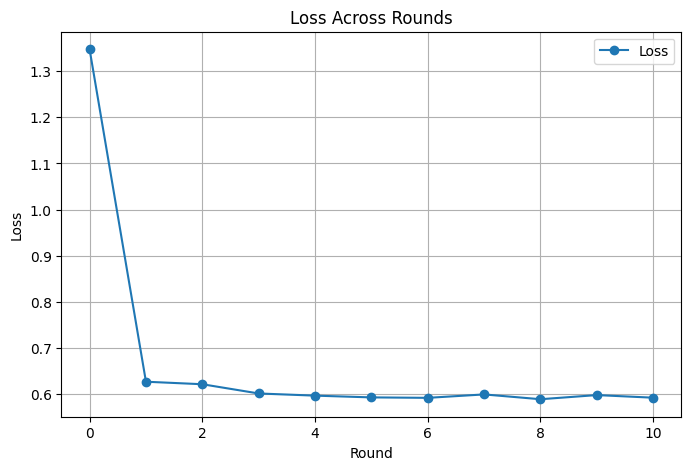

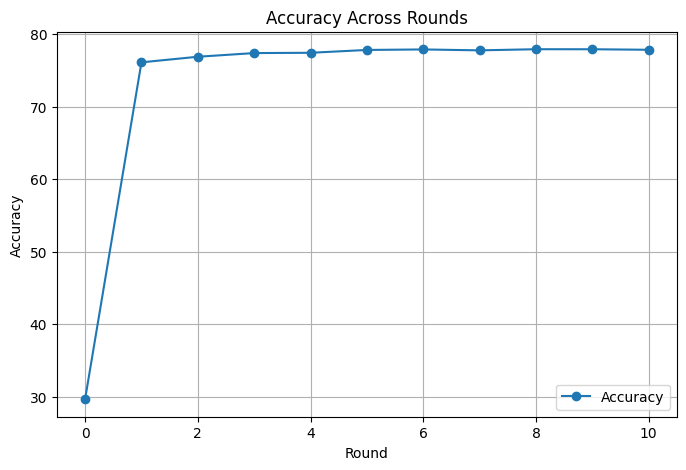

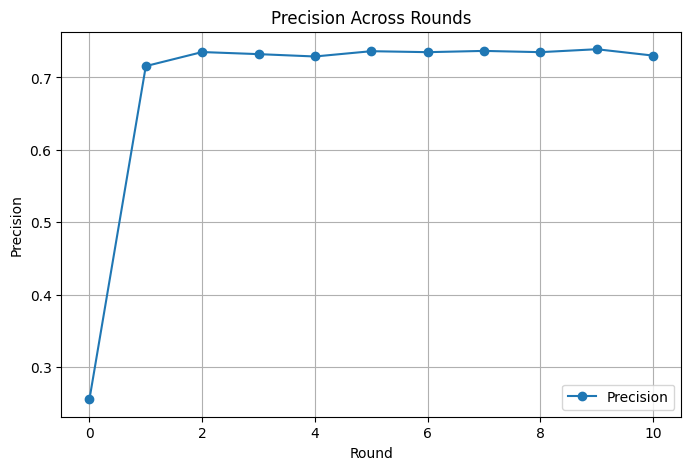

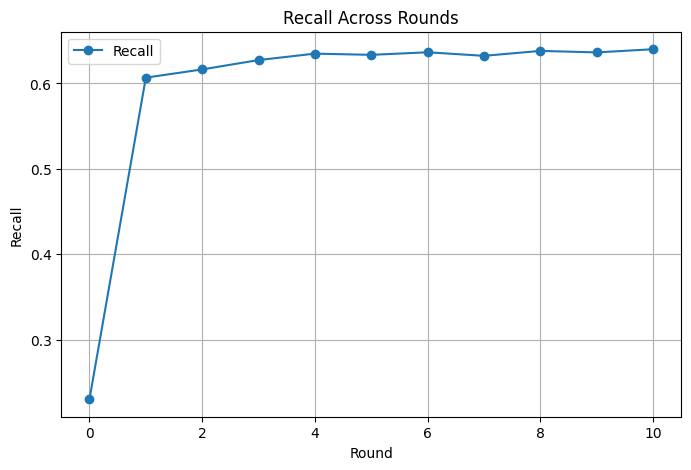

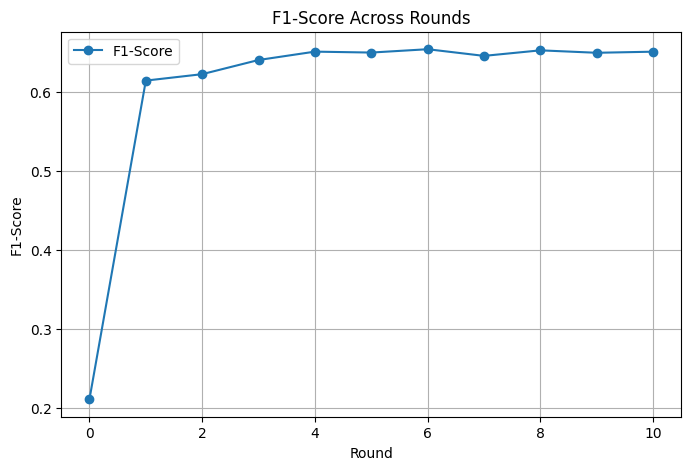

In [27]:
# DataFrame to store the metrics
iid_metrics_df = pd.DataFrame({
    "Round": list(rounds),
    "Loss": iid_results["losses"],
    "Accuracy": iid_results["accuracies"],
    "Precision": iid_results["precisions"],
    "Recall": iid_results["recalls"],
    "F1-Score": iid_results["f1_scores"]
})


# Accuracy, Precision, Recall, and F1-Score
metrics_to_plot = ["Loss","Accuracy", "Precision", "Recall", "F1-Score"]

for metric in metrics_to_plot:
    plt.figure(figsize=(8, 5))
    plt.plot(iid_metrics_df["Round"], iid_metrics_df[metric], marker='o', label=metric)
    plt.title(f"{metric} Across Rounds")
    plt.xlabel("Round")
    plt.ylabel(metric)
    plt.grid(True)
    plt.legend()
    plt.show()

iid_metrics_df.to_csv("FedFlower_metrics.csv", index=False)

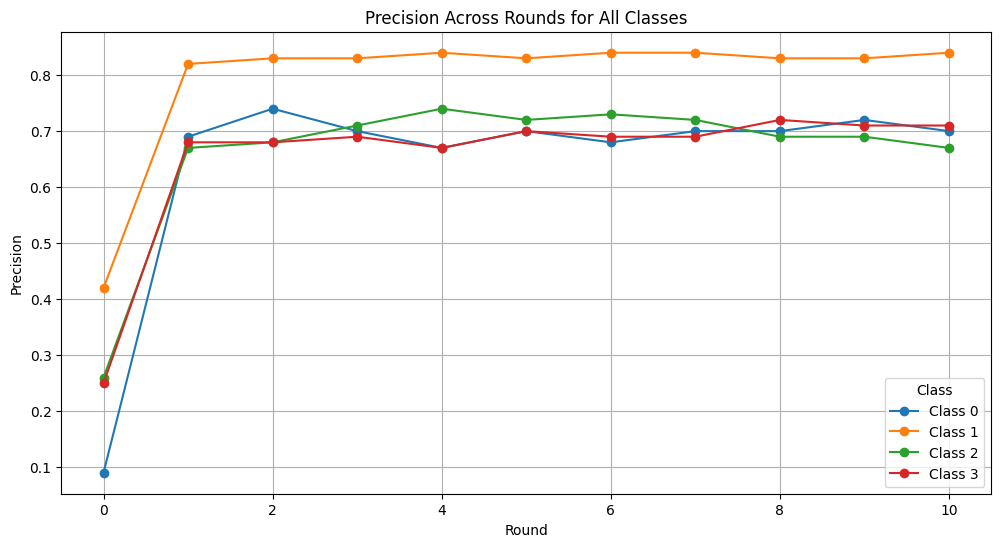

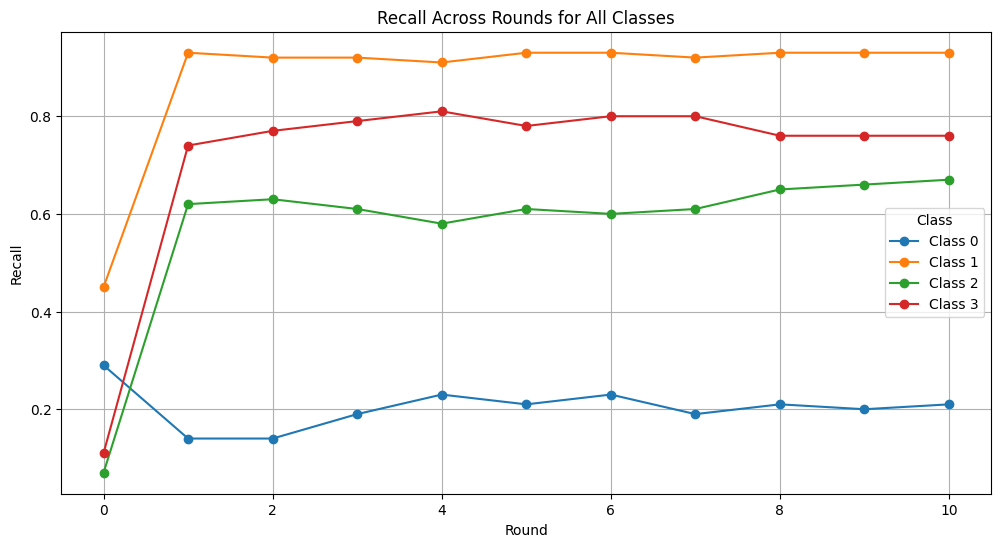

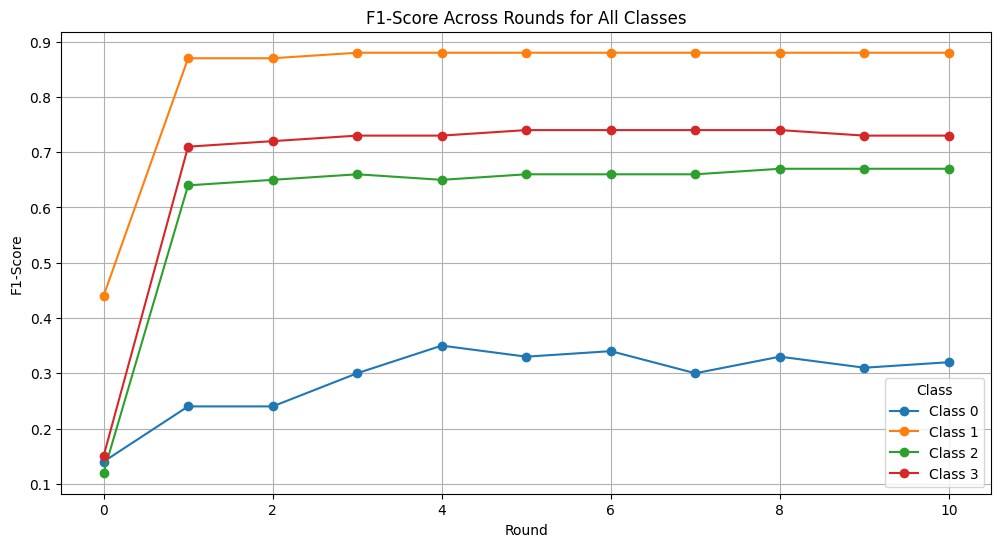

In [28]:
# Filter the DataFrame for classes only (exclude macro and weighted averages)
class_filter = iid_results["all_reports"]["Class"].str.contains("Class")
class_reports = iid_results["all_reports"][class_filter]

# Define the metrics to plot
metrics = ["Precision", "Recall", "F1-Score"]

for metric in metrics:
    plt.figure(figsize=(12, 6))
    for cls in class_reports["Class"].unique():
        subset = class_reports[class_reports["Class"] == cls]
        plt.plot(subset["Round"], subset[metric], marker='o', label=f"{cls}")
    plt.title(f"{metric} Across Rounds for All Classes")
    plt.xlabel("Round")
    plt.ylabel(metric)
    plt.legend(title="Class")
    plt.grid(True)
    plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Confusion Matrix for Round 0:
[[ 554 1079   50  233]
 [4552 4620  211  948]
 [ 358 1953  218  403]
 [ 627 3250  374  532]]


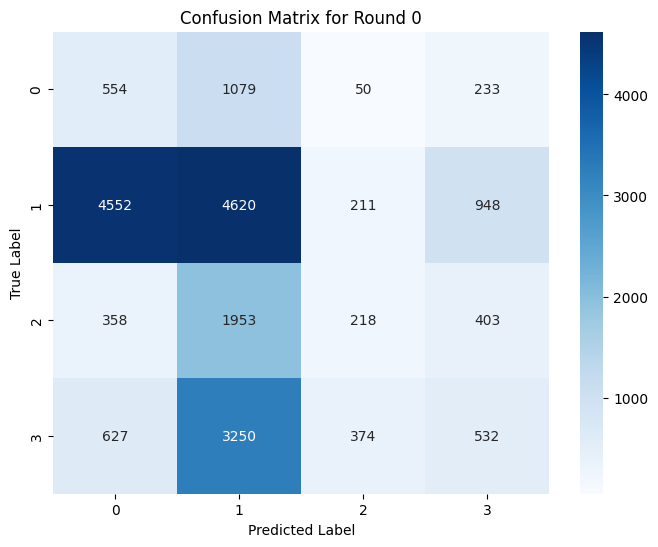

Confusion Matrix for Round 1:
[[ 272 1253  176  215]
 [  97 9569  129  536]
 [  11  223 1815  883]
 [  14  635  594 3540]]


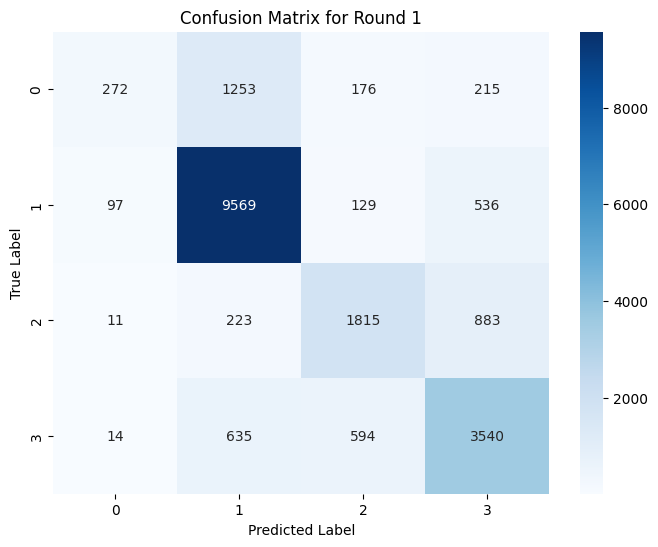

Confusion Matrix for Round 2:
[[ 271 1243  181  221]
 [  76 9545  128  582]
 [   7  178 1845  902]
 [  10  531  553 3689]]


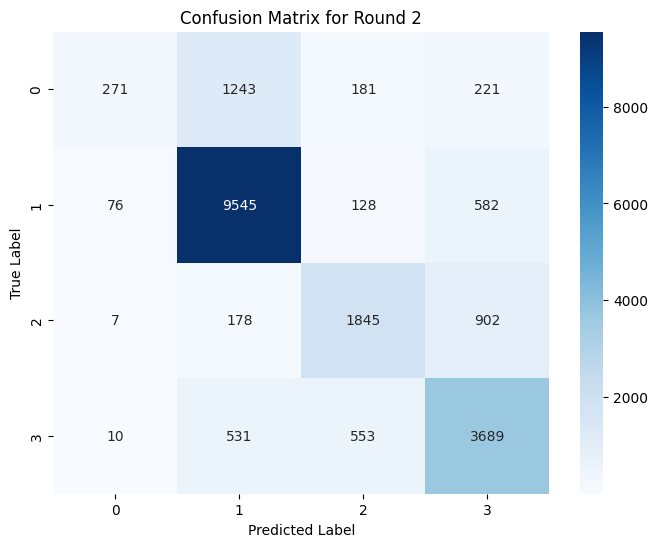

Confusion Matrix for Round 3:
[[ 364 1184  152  216]
 [ 125 9533  103  570]
 [  15  186 1786  945]
 [  16  521  478 3768]]


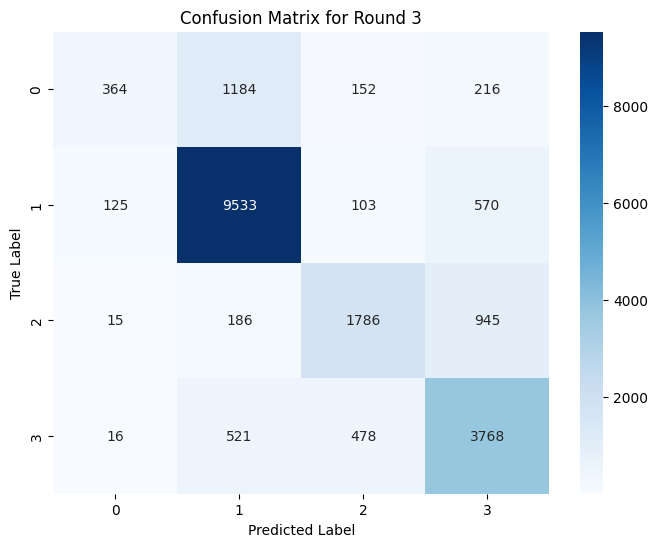

Confusion Matrix for Round 4:
[[ 447 1111  127  231]
 [ 184 9413   83  651]
 [  18  162 1703 1049]
 [  22  467  398 3896]]


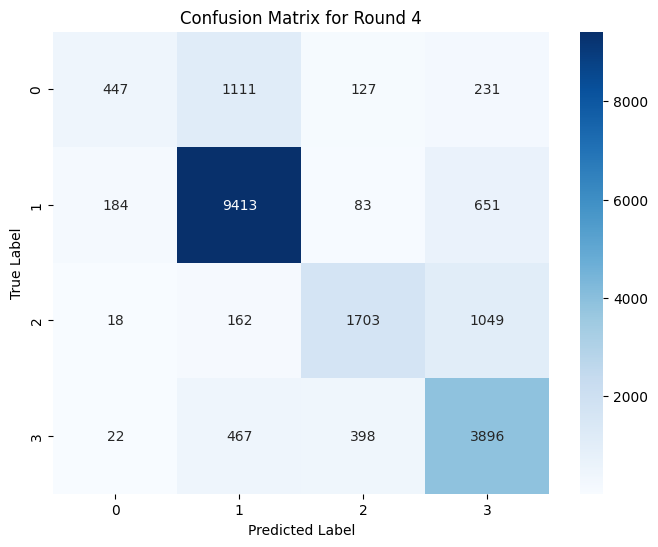

Confusion Matrix for Round 5:
[[ 409 1191  139  177]
 [ 137 9595   96  503]
 [  18  188 1781  945]
 [  22  536  473 3752]]


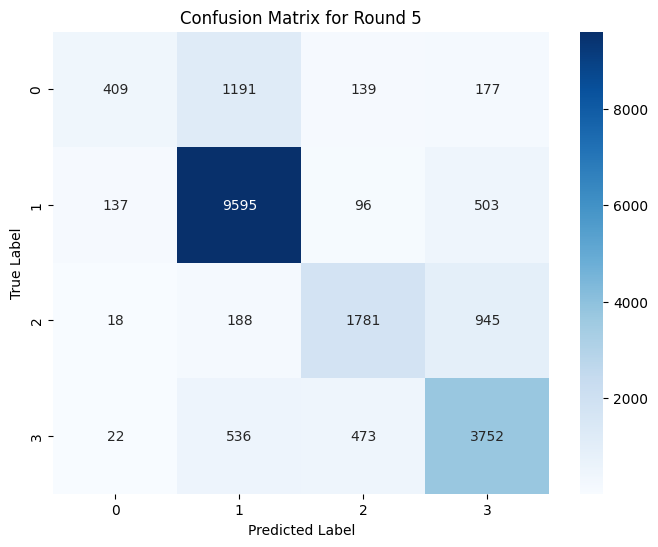

Confusion Matrix for Round 6:
[[ 435 1166  131  184]
 [ 166 9557   82  526]
 [  18  187 1756  971]
 [  23  531  426 3803]]


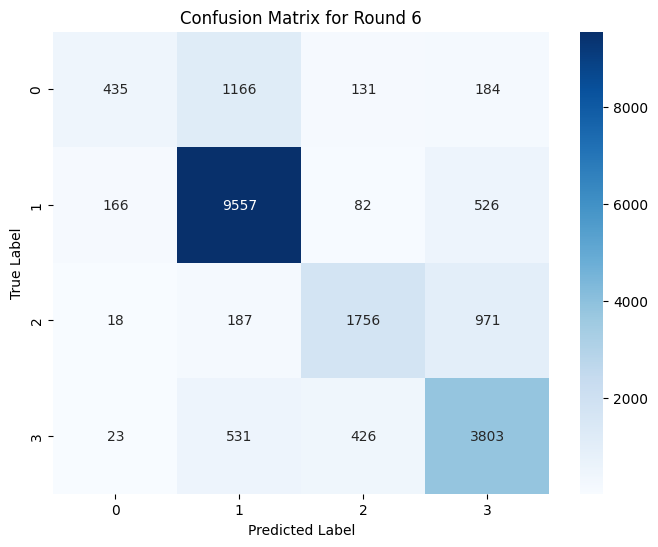

Confusion Matrix for Round 7:
[[ 373 1191  143  209]
 [ 131 9539  100  561]
 [  12  173 1801  946]
 [  15  487  468 3813]]


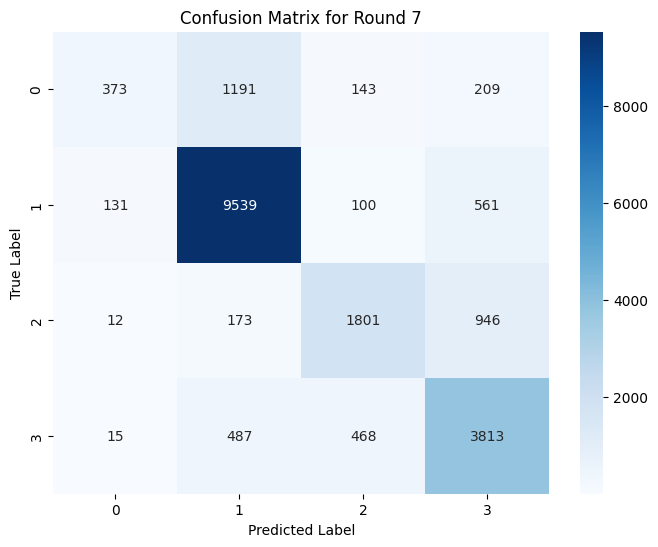

Confusion Matrix for Round 8:
[[ 409 1194  151  162]
 [ 144 9618  114  455]
 [  12  189 1909  822]
 [  19  556  587 3621]]


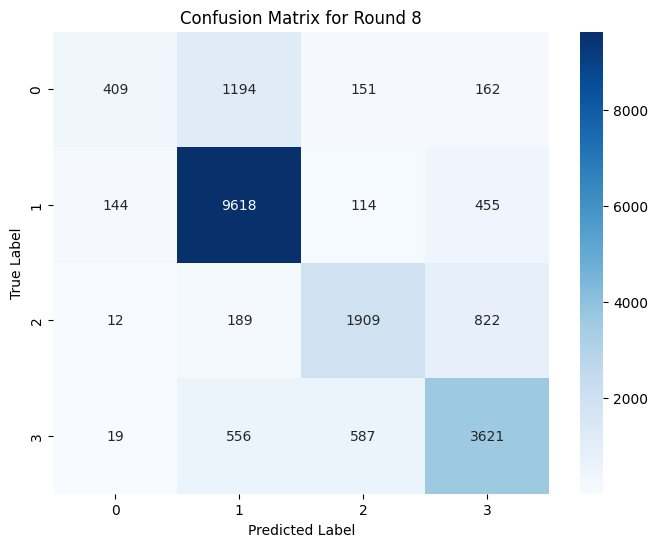

Confusion Matrix for Round 9:
[[ 384 1210  159  163]
 [ 121 9629  110  471]
 [  12  183 1926  811]
 [  16  548  602 3617]]


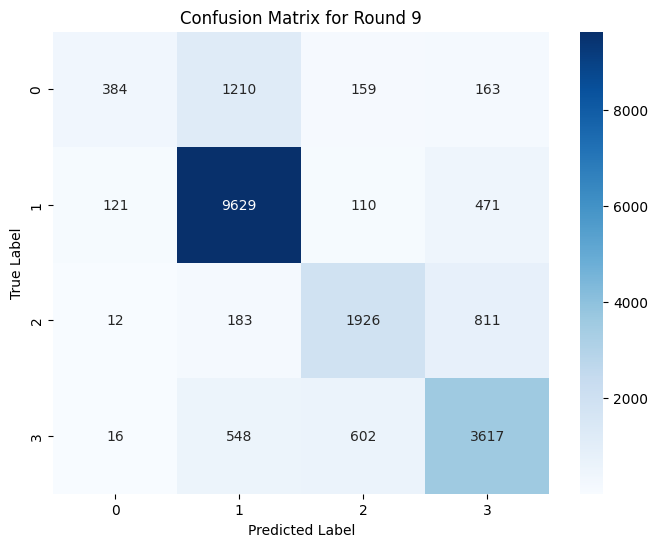

Confusion Matrix for Round 10:
[[ 399 1172  170  175]
 [ 143 9557  129  502]
 [  13  160 1964  795]
 [  17  483  661 3622]]


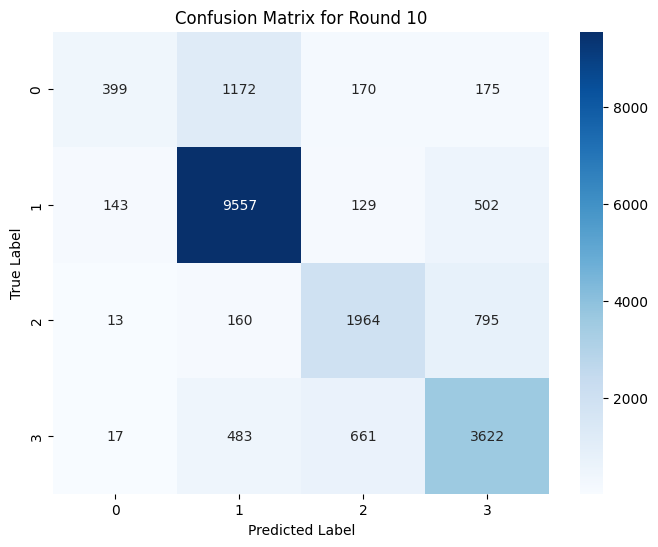

In [30]:
for i, cm in enumerate(iid_results["confusion_matrices"]):
    if cm is not None:
        print(f"Confusion Matrix for Round {i}:")
        print(cm)

        # Visualize the confusion matrix
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=True, yticklabels=True)
        plt.title(f"Confusion Matrix for Round {i}")
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.show()
    else:
        print(f"No Confusion Matrix available for Round {i}")

**Analysis of Performance**

Our evaluations in classification report reveal a disparity in the model's performance across classes, with Class 1 achieving the highest metrics (precision, recall, and F1-score), while Class 0 demonstrates the poorest performance.

This discrepancy may be attributed to an imbalance in the training data, where Class 1 likely had a larger representation, enabling the model to learn its features more effectively. To further understand this phenomenon, we conducted an investigation into the distribution of training data across classes.




Insights from the confusion matrix:
- Class Imbalance: Class 1 ("Not Male & Young") has disproportionately higher true positives, indicating either:
    - A higher number of samples in this class.
    - The model is biased toward predicting this class.
- Confusions:
    - Class 0 ("Not Male & Not Young") is frequently misclassified as Class 1.
    - Class 3 ("Male & Young") is confused with Class 2 ("Male & Not Young").



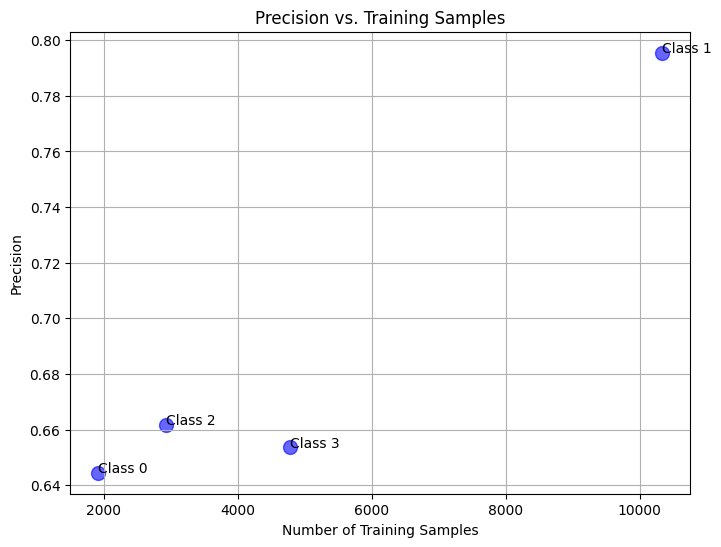

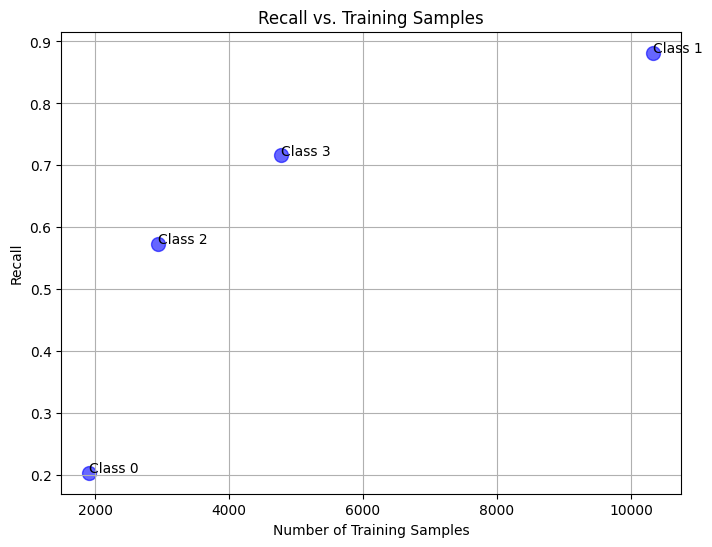

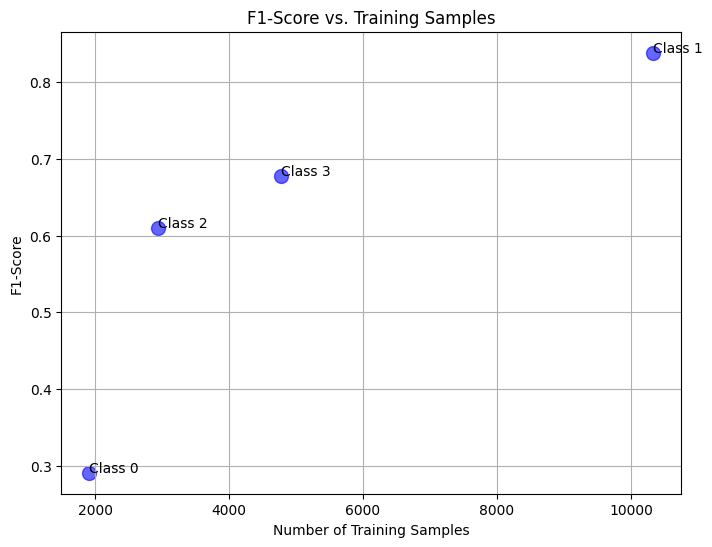

In [22]:
metrics_support = class_reports.groupby("Class")[["Precision", "Recall", "F1-Score", "Support"]].mean().reset_index()
counts = metrics_support["Support"].values

# Plot metrics vs. support
for metric in ["Precision", "Recall", "F1-Score"]:
    plt.figure(figsize=(8, 6))
    plt.scatter(counts, metrics_support[metric], s=100, c='blue', alpha=0.6)
    for i, cls in enumerate(metrics_support["Class"]):
        plt.text(counts[i], metrics_support[metric][i], cls, fontsize=10)
    plt.title(f"{metric} vs. Training Samples")
    plt.xlabel("Number of Training Samples")
    plt.ylabel(metric)
    plt.grid(True)
    plt.show()

**Impact of Training Data Imbalance on Model Performance**

The observed relationship between training data size and performance demonstrates that the model is inherently biased towards the dominant class (Class 1), which has the largest representation in the training dataset. Conversely, the model exhibits poor performance on the least represented class (Class 0). When Class 0 has significantly fewer samples compared to Class 1, the model receives limited opportunities to learn and generalize the features of Class 0 effectively. This imbalance naturally shifts the model’s focus towards the dominant class, resulting in disproportionately better performance for Class 1.

**Solution: Model and Data Adjustments**

- Data-Level Solutions:
    - Oversample Class 0 using methods like SMOTE or random oversampling.
    - Undersample dominant classes (e.g., Class 1) to balance the dataset.


- Algorithm-Level Solutions:
    - Use class weights in the loss function (e.g., class_weight='balanced' in scikit-learn).
    - Train with loss functions designed for imbalanced data, like focal loss.


### Non-IID

In [31]:
non_iid_base_dir = "/content/drive/MyDrive/2024/Telefonica/Results_FedFlower/non_iid_1"
rounds = range(0, 11)

non_iid_results = process_results(non_iid_base_dir, rounds)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


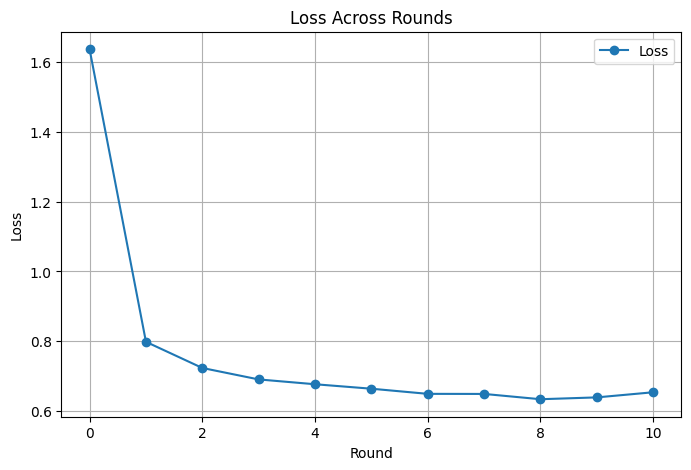

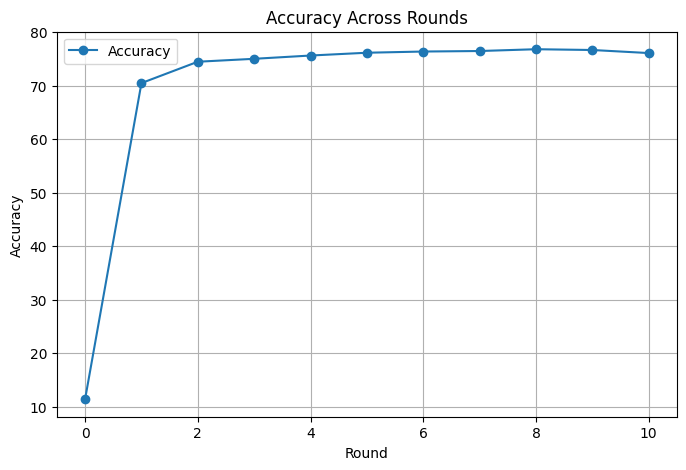

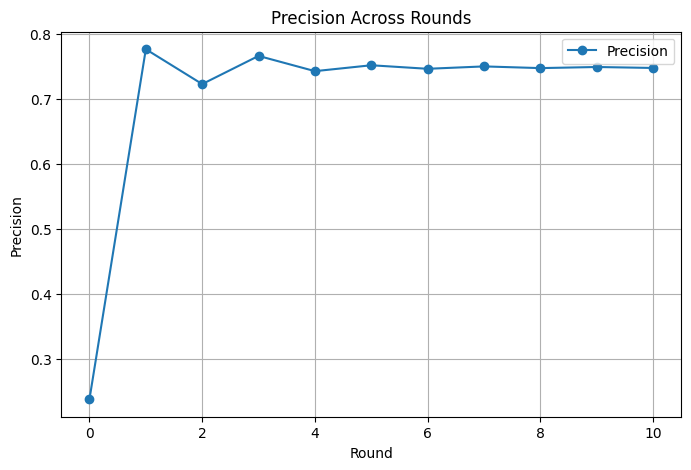

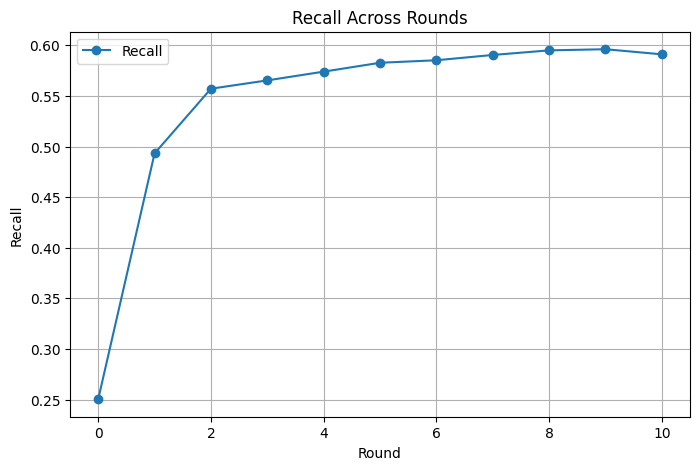

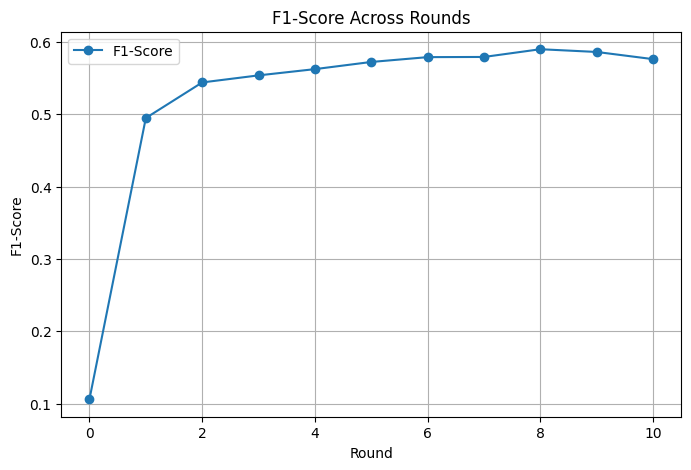

In [32]:
# DataFrame to store the metrics
non_iid_metrics_df = pd.DataFrame({
    "Round": list(rounds),
    "Loss": non_iid_results["losses"],
    "Accuracy": non_iid_results["accuracies"],
    "Precision": non_iid_results["precisions"],
    "Recall": non_iid_results["recalls"],
    "F1-Score": non_iid_results["f1_scores"]
})


# Accuracy, Precision, Recall, and F1-Score
metrics_to_plot = ["Loss","Accuracy", "Precision", "Recall", "F1-Score"]

for metric in metrics_to_plot:
    plt.figure(figsize=(8, 5))
    plt.plot(iid_metrics_df["Round"], non_iid_metrics_df[metric], marker='o', label=metric)
    plt.title(f"{metric} Across Rounds")
    plt.xlabel("Round")
    plt.ylabel(metric)
    plt.grid(True)
    plt.legend()
    plt.show()

iid_metrics_df.to_csv("FedFlower_metrics.csv", index=False)

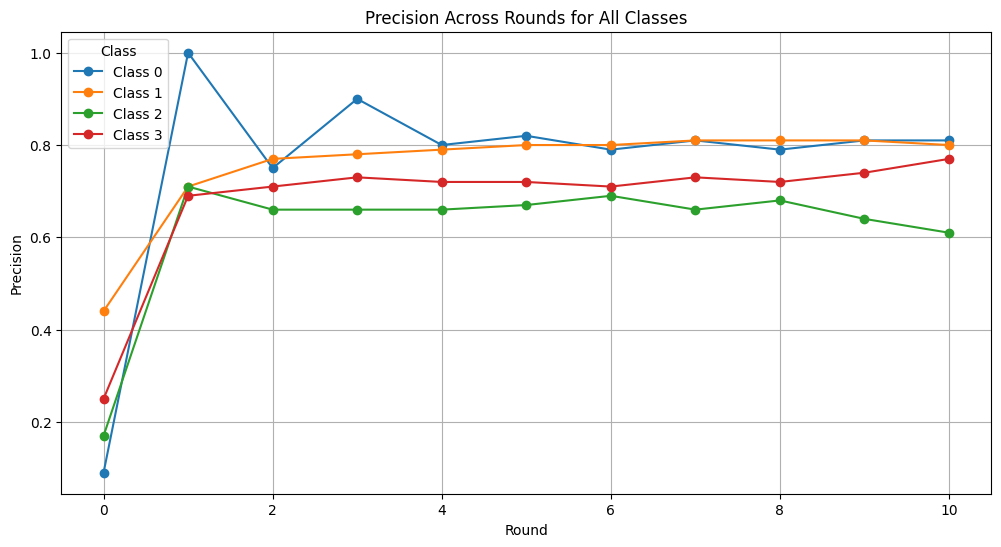

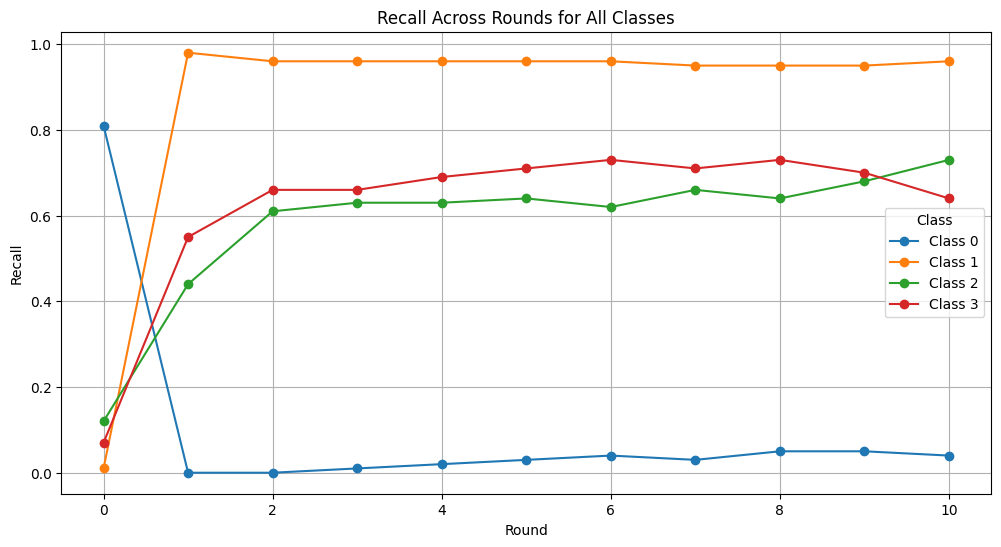

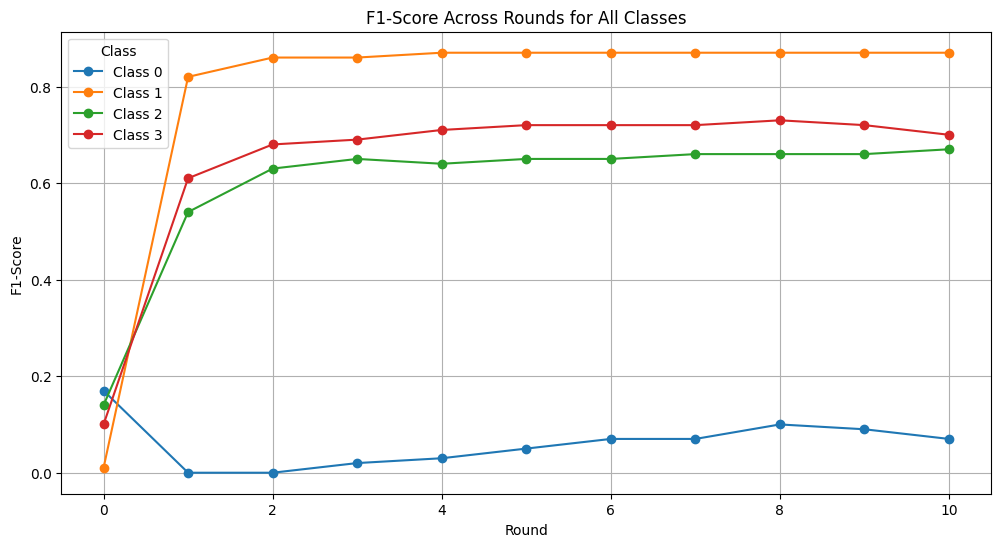

In [33]:
# Filter the DataFrame for classes only (exclude macro and weighted averages)
class_filter = non_iid_results["all_reports"]["Class"].str.contains("Class")
class_reports = non_iid_results["all_reports"][class_filter]

# Define the metrics to plot
metrics = ["Precision", "Recall", "F1-Score"]

for metric in metrics:
    plt.figure(figsize=(12, 6))
    for cls in class_reports["Class"].unique():
        subset = class_reports[class_reports["Class"] == cls]
        plt.plot(subset["Round"], subset[metric], marker='o', label=f"{cls}")
    plt.title(f"{metric} Across Rounds for All Classes")
    plt.xlabel("Round")
    plt.ylabel(metric)
    plt.legend(title="Class")
    plt.grid(True)
    plt.show()

Confusion Matrix for Round 0:
[[1555    6  208  147]
 [8818   69  920  524]
 [2311   24  344  253]
 [3848   59  562  314]]


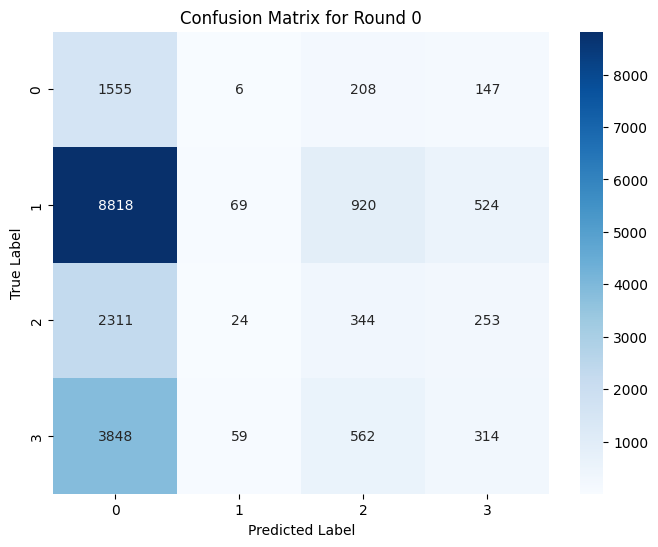

Confusion Matrix for Round 1:
[[    1  1734    55   126]
 [    0 10132    45   154]
 [    0   731  1287   914]
 [    0  1715   424  2644]]


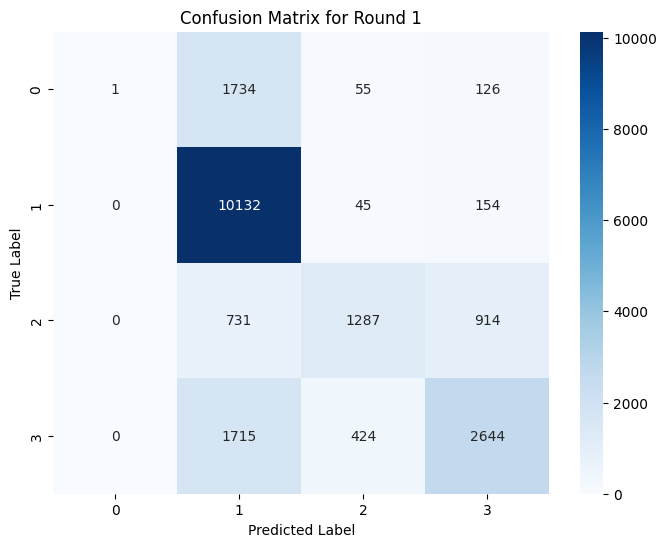

Confusion Matrix for Round 2:
[[   3 1589  152  172]
 [   1 9921  103  306]
 [   0  349 1779  804]
 [   0  954  672 3157]]


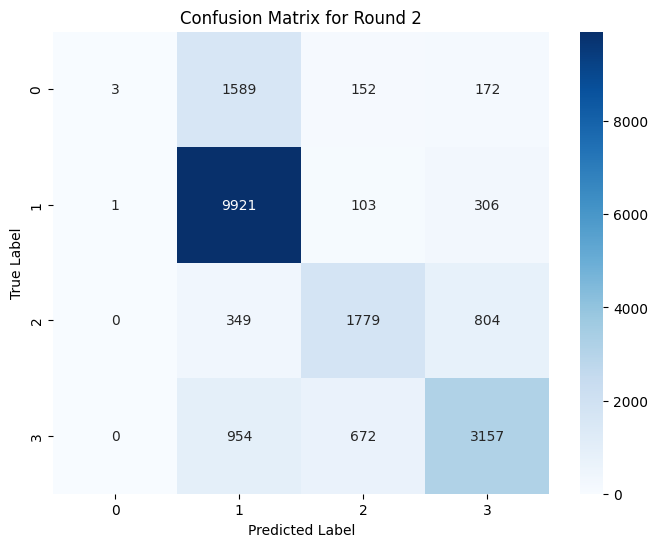

Confusion Matrix for Round 3:
[[  18 1581  169  148]
 [   1 9961   98  271]
 [   0  348 1854  730]
 [   1  953  693 3136]]


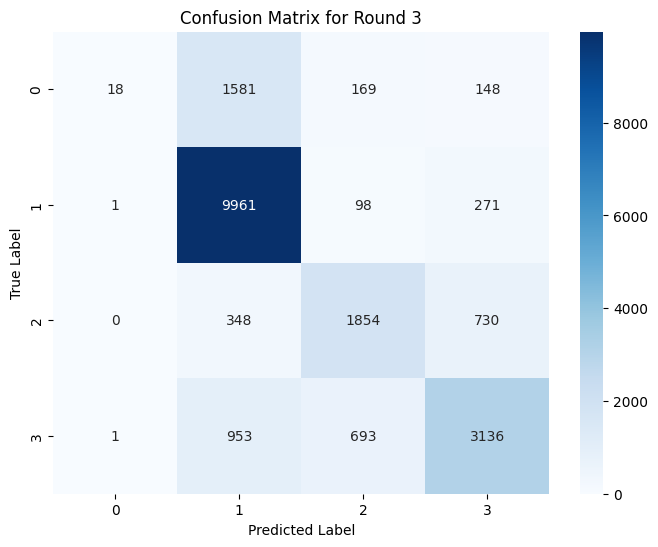

Confusion Matrix for Round 4:
[[  32 1523  179  182]
 [   5 9904  112  310]
 [   0  297 1841  794]
 [   3  819  647 3314]]


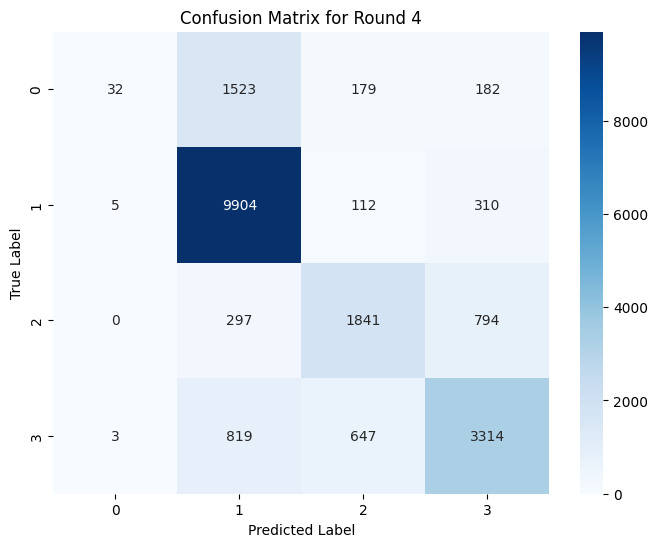

Confusion Matrix for Round 5:
[[  51 1497  183  185]
 [   8 9871  115  337]
 [   0  267 1869  796]
 [   3  745  631 3404]]


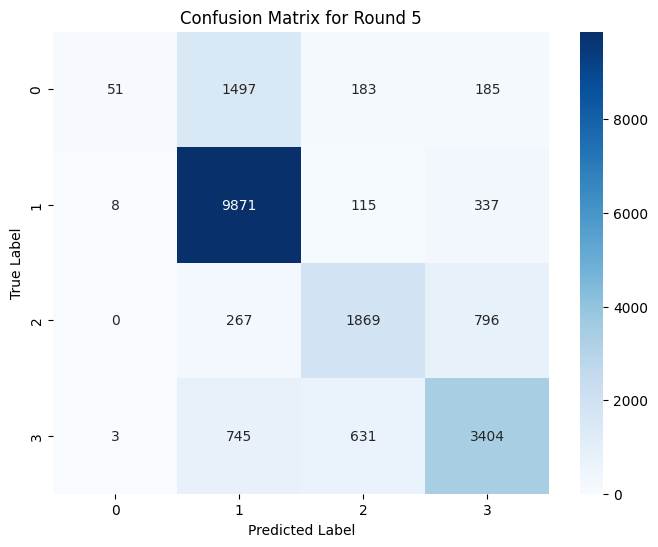

Confusion Matrix for Round 6:
[[  74 1484  166  192]
 [  14 9873   95  349]
 [   2  258 1820  852]
 [   4  737  569 3473]]


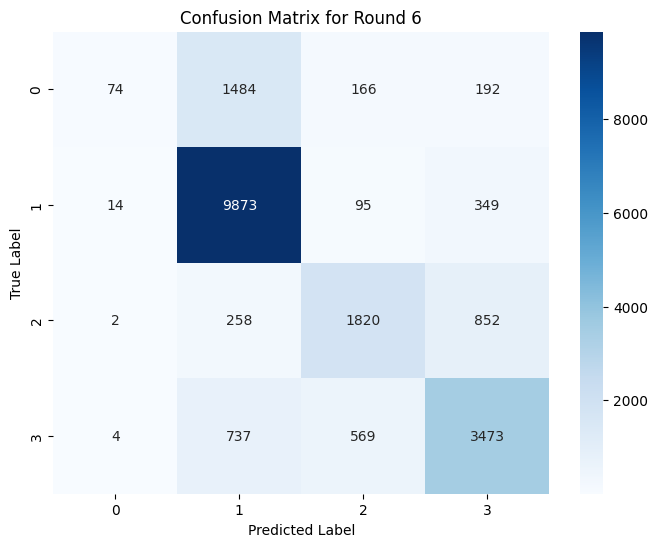

Confusion Matrix for Round 7:
[[  66 1470  199  181]
 [  11 9843  119  358]
 [   1  243 1942  746]
 [   3  670  702 3408]]


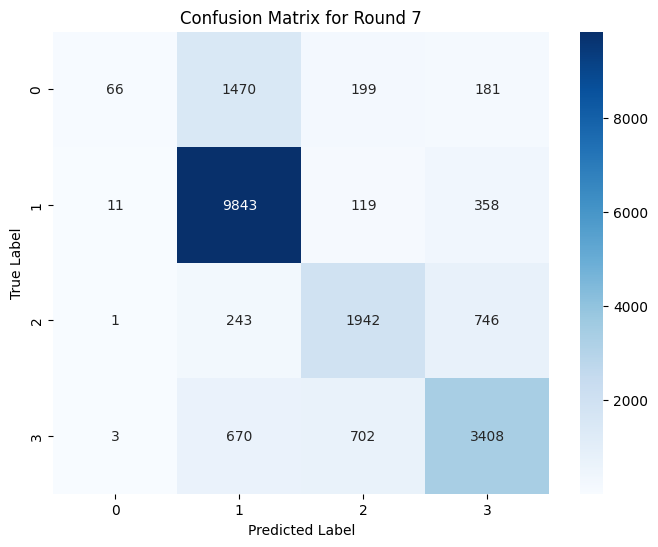

Confusion Matrix for Round 8:
[[ 103 1449  175  189]
 [  20 9847  109  355]
 [   3  249 1889  791]
 [   5  668  623 3487]]


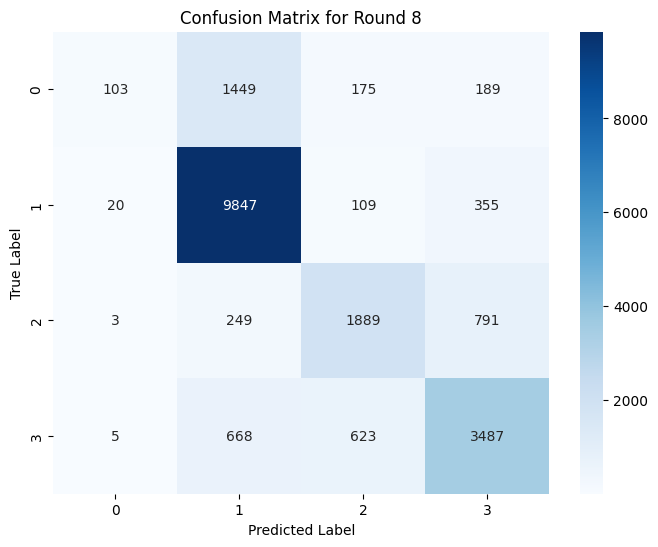

Confusion Matrix for Round 9:
[[  89 1447  210  170]
 [  15 9844  130  342]
 [   2  234 2000  696]
 [   4  654  761 3364]]


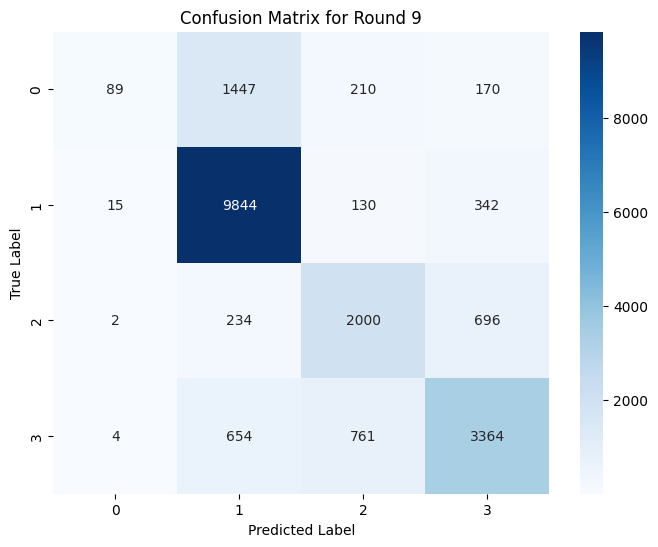

Confusion Matrix for Round 10:
[[  70 1485  224  137]
 [  11 9920  149  251]
 [   2  246 2137  547]
 [   3  743  981 3056]]


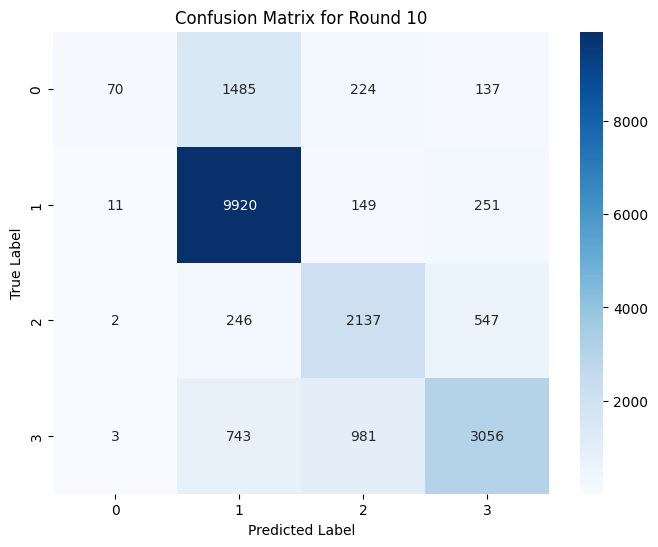

In [34]:
for i, cm in enumerate(non_iid_results["confusion_matrices"]):
    if cm is not None:
        print(f"Confusion Matrix for Round {i}:")
        print(cm)

        # Visualize the confusion matrix
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=True, yticklabels=True)
        plt.title(f"Confusion Matrix for Round {i}")
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.show()
    else:
        print(f"No Confusion Matrix available for Round {i}")

#### Performance Comparision

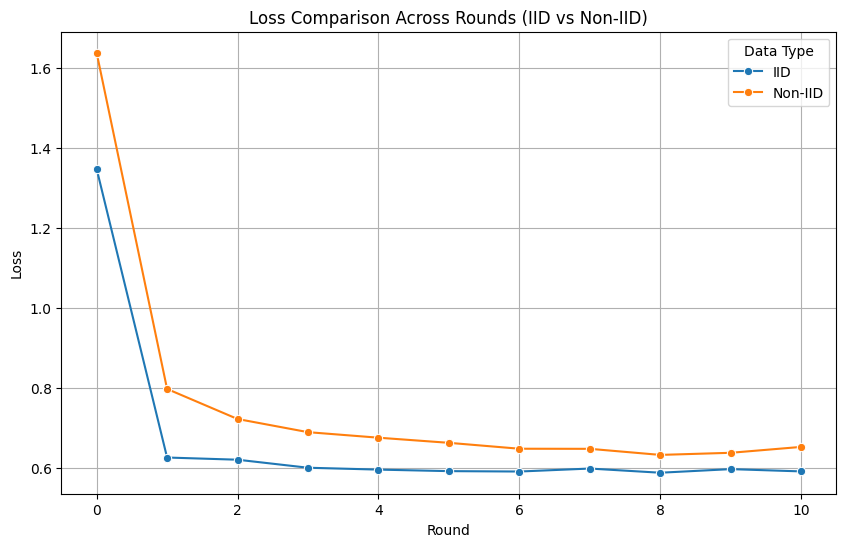

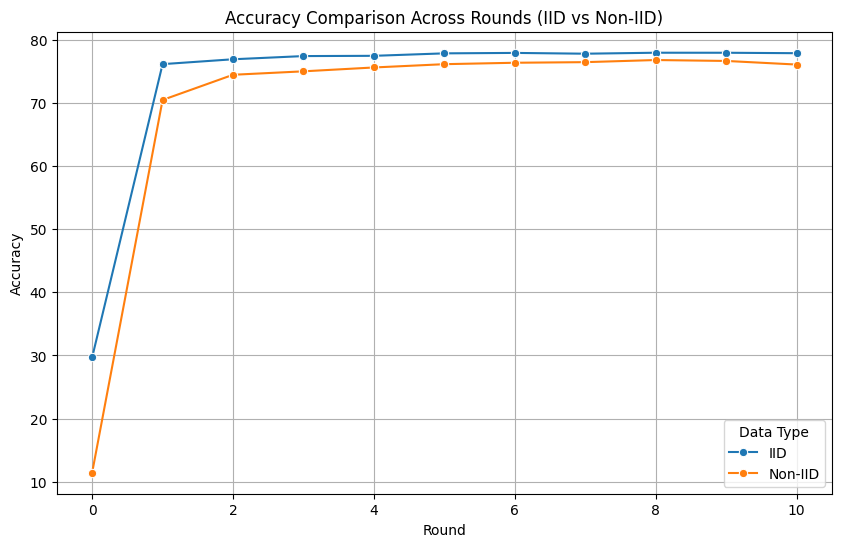

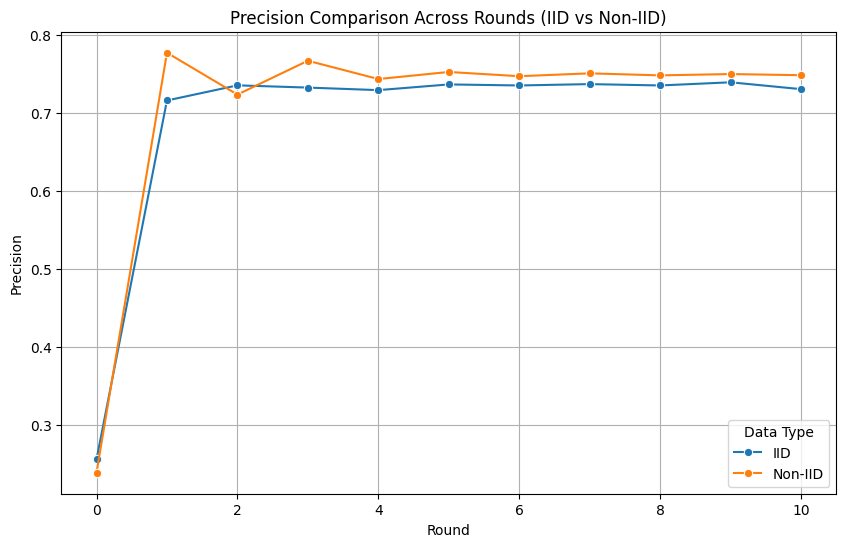

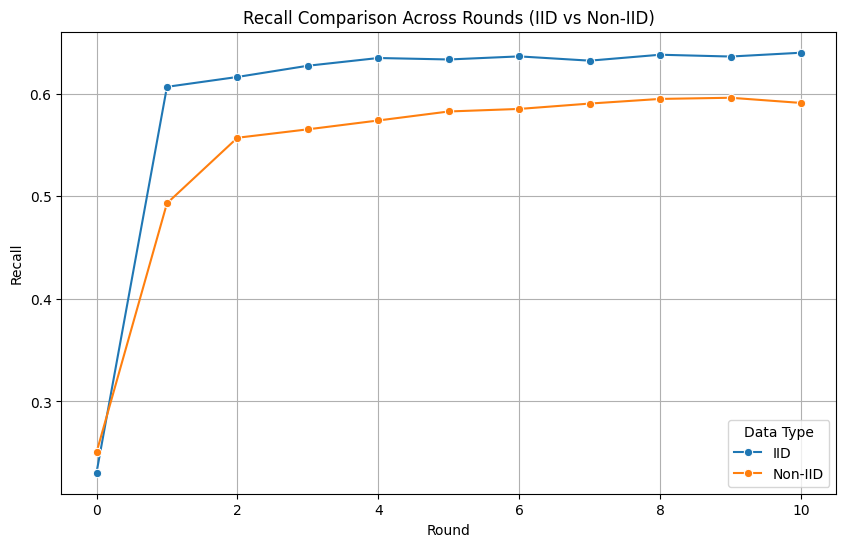

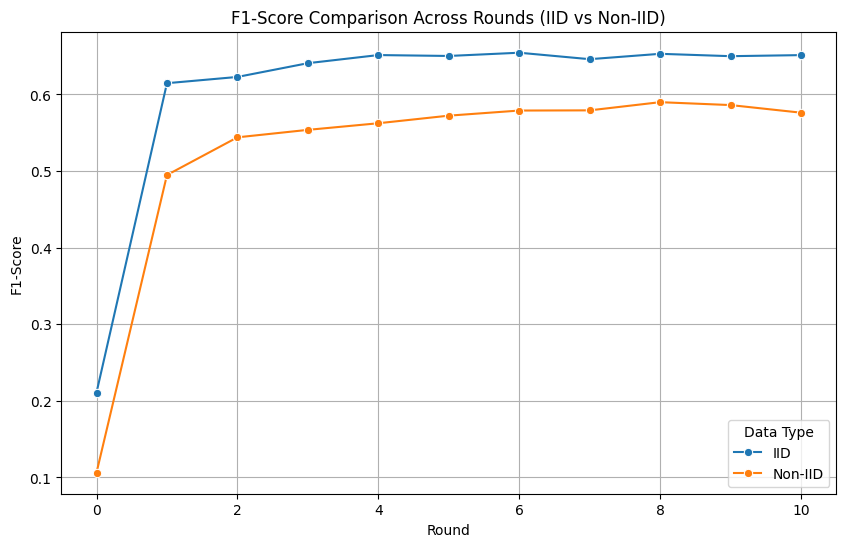

In [37]:
# Combine the DataFrames, adding a 'Type' column to distinguish between IID and Non-IID
combined_metrics_df = pd.concat([
    iid_metrics_df.assign(Type='IID'),
    non_iid_metrics_df.assign(Type='Non-IID')
], ignore_index=True)

# Metrics to compare
metrics_to_compare = ["Loss", "Accuracy", "Precision", "Recall", "F1-Score"]

# Plot comparison for each metric
for metric in metrics_to_compare:
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=combined_metrics_df, x="Round", y=metric, hue="Type", marker="o") # 'Type' column is now available for hue
    plt.title(f"{metric} Comparison Across Rounds (IID vs Non-IID)")
    plt.xlabel("Round")
    plt.ylabel(metric)
    plt.grid(True)
    plt.legend(title="Data Type")
    plt.show()

**Convergence**:

- The Non-IID setting shows slower convergence compared to the IID setting, which is evident from the loss across the rounds.
- The IID model's loss decreases more rapidly, reflecting faster optimization and stabilization during training.

**Overall Performance**:

- The IID setting demonstrates better performance overall, especially in terms of:
  - Accuracy: Higher accuracy indicates better generalization on the IID data.
  - Recall and F1-Score: The IID model is particularly stronger in these metrics, suggesting that it:
    - Captures more true positives (high recall).
    - Maintains a better balance between precision and recall (high F1-Score).
- The Non-IID setting, likely affected by data heterogeneity and imbalances, struggles to achieve comparable recall and F1-scores.


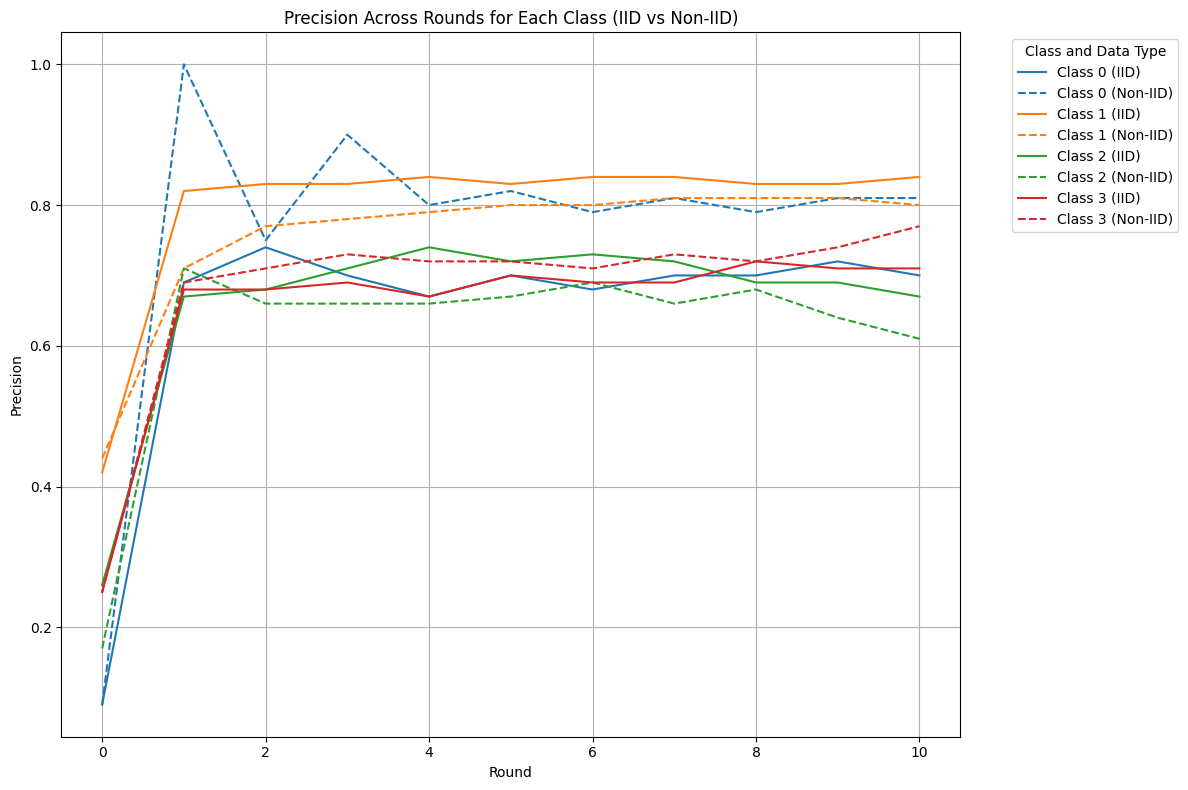

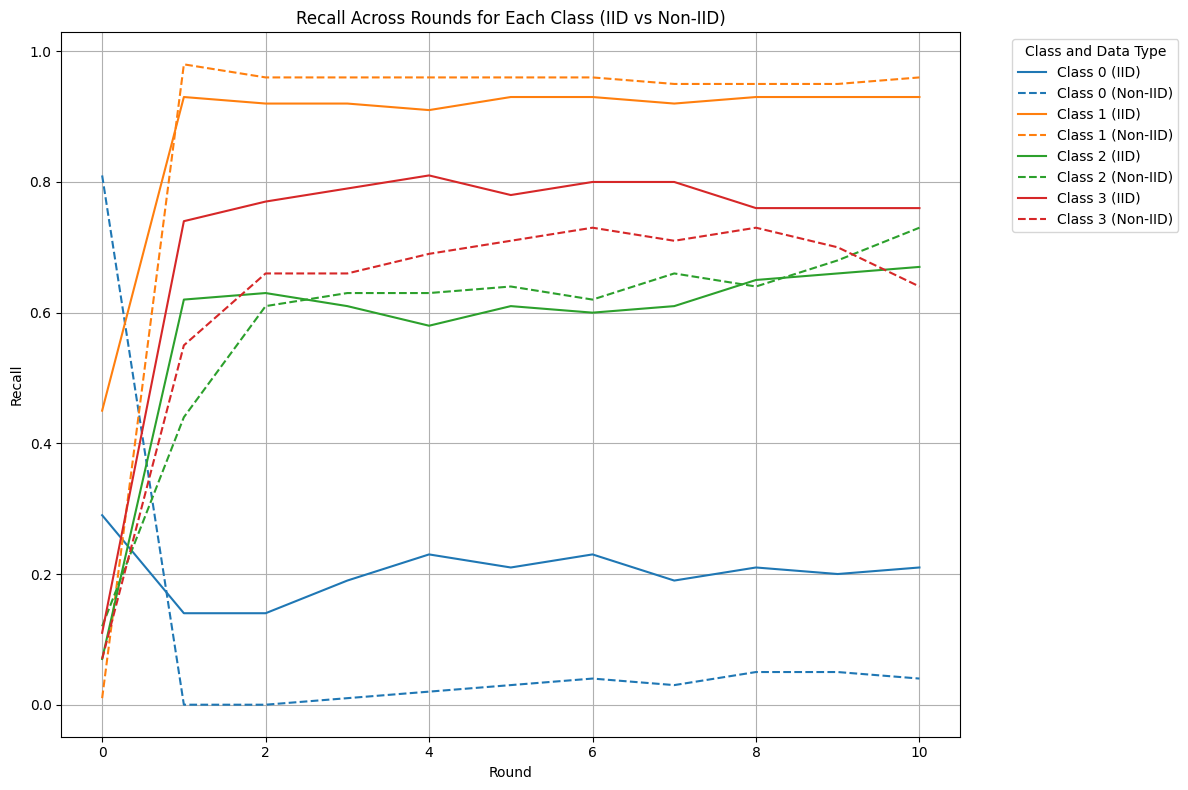

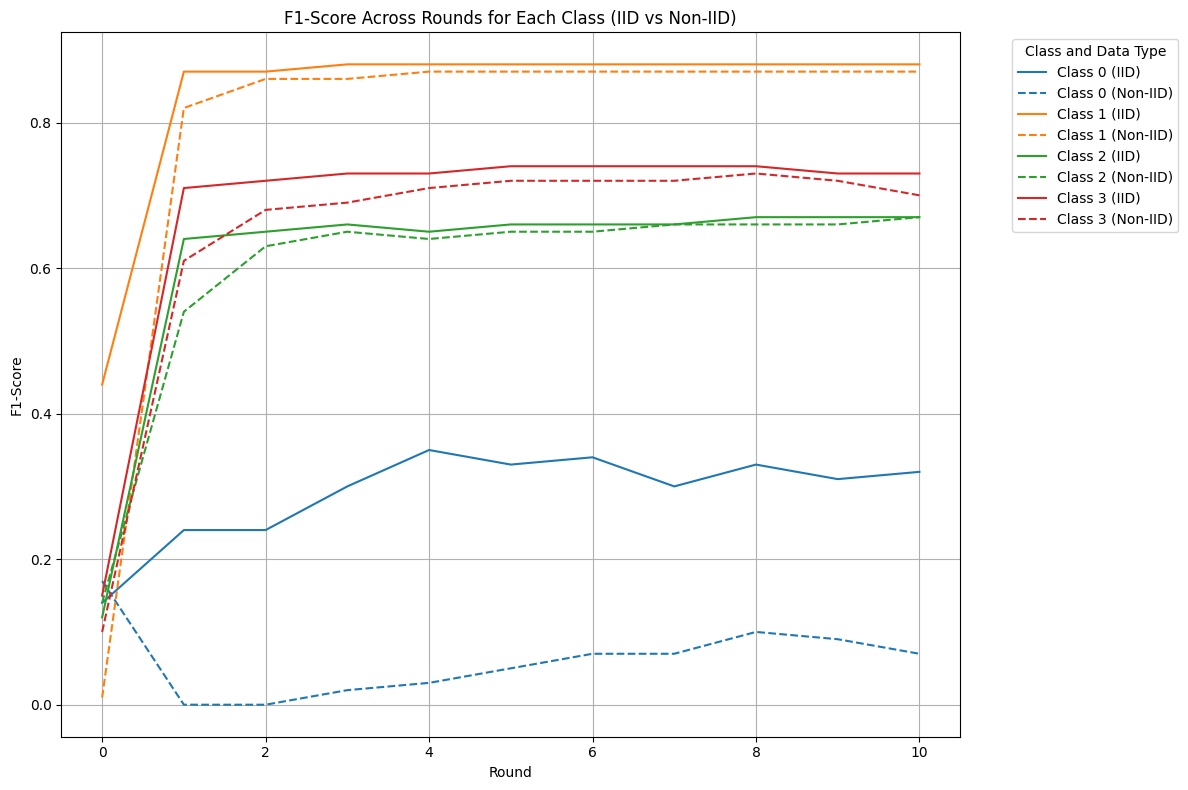

In [41]:
# Filter class-specific reports for IID and Non-IID
iid_class_filter = iid_results["all_reports"]["Class"].str.contains("Class")
iid_class_reports = iid_results["all_reports"][iid_class_filter]

non_iid_class_filter = non_iid_results["all_reports"]["Class"].str.contains("Class")
non_iid_class_reports = non_iid_results["all_reports"][non_iid_class_filter]

# Define metrics and line styles
metrics_to_compare = ["Precision", "Recall", "F1-Score"]
line_styles = {"IID": "-", "Non-IID": "--"}

# Define classes and color palette
classes = iid_class_reports["Class"].unique()
colors = plt.cm.tab10(range(len(classes)))

# Plot each metric
for metric in metrics_to_compare:
    plt.figure(figsize=(12, 8))

    for idx, cls in enumerate(classes):
        # IID data
        iid_subset = iid_class_reports[iid_class_reports["Class"] == cls]
        plt.plot(
            iid_subset["Round"],
            iid_subset[metric],
            linestyle=line_styles["IID"],
            color=colors[idx],
            label=f"{cls} (IID)"
        )

        # Non-IID data
        non_iid_subset = non_iid_class_reports[non_iid_class_reports["Class"] == cls]
        plt.plot(
            non_iid_subset["Round"],
            non_iid_subset[metric],
            linestyle=line_styles["Non-IID"],
            color=colors[idx],
            label=f"{cls} (Non-IID)"
        )

    # Add title, labels, and legend
    plt.title(f"{metric} Across Rounds for Each Class (IID vs Non-IID)")
    plt.xlabel("Round")
    plt.ylabel(metric)
    plt.grid(True)
    plt.legend(title="Class and Data Type", loc="upper left", bbox_to_anchor=(1.05, 1), fontsize=10)
    plt.tight_layout()

    # Show the plot
    plt.show()


**Per Class Performance**:


 IID Setting:
  - Generally demonstrates better performance across classes, with consistently higher scores than Non-iid setting.

Non-IID Setting:
  - Performance is not stable, especially during the early rounds, where significant fluctuations are observed.



# Assumptions and Parameter Settings

This section outlines the assumptions made during the project, along with the specific parameter values and configurations used in the implementation and experiments.






### Assumptions

1. Data Availability:
   - The CelebA dataset is assumed to be available and correctly downloaded into the `data/` directory.
   - Each client is assumed to have access to a balanced or imbalanced subset of the data, depending on the partitioning strategy (IID or non-IID).

2. Demographic Labels:
   - The demographic labels (`Male` and `Young`) in the dataset are binary attributes (0 or 1) and are used to create four demographic groups for classification.

3. Federated Learning Environment:
   - Communication between clients and the server is assumed to be reliable with no dropped connections during simulation.

4. Model Training:
   - The model is pre-trained (MobileNetV2), and only the classifier head is trainable to reduce computational complexity.

### Parameter Settings

#### Federated Learning Configuration
- Number of Clients (Partitions): `NUM_PARTITIONS = 50`
- Communication Rounds: `10`
- Strategy: Federated Averaging (FedAvg)

#### Data Partitioning
- Partitioning Strategies:
  - IID: Data is evenly distributed among clients.
  - Non-IID: A Visual Dirichlet partitioner is used with `alpha=0.5` to create imbalanced client datasets.
- Train-Validation Split: 80% training, 20% validation for each client.

#### Model Configuration
- Base Model: Pre-trained MobileNetV2
- Classifier Head:
  - Input Size: 1280 (MobileNetV2 output features)
  - Output Size: 4 (Demographic labels)


#### Training Parameters
- Optimizer: Adam
  - Learning Rate: `0.001`
  - Weight Decay: `1e-4`
- Batch Size: `8`
- Local Epochs: `1`
- Loss Function: CrossEntropyLoss
- Learning Rate Scheduler: Reduces learning rate by a factor of 0.1 when validation loss stagnates.

#### Evaluation Metrics
- Accuracy: Percentage of correctly predicted samples.
- Precision, Recall, and F1-Score: Computed for each class and averaged using the macro method.
- Confusion Matrix: Captures class-wise prediction errors.




### Assumptions and Their Justifications

1. Pre-Trained Model:
   - Assumed that using MobileNetV2 with a frozen feature extractor would reduce computational overhead while maintaining high accuracy.

2. Learning Rate:
   - The initial learning rate of `0.001` was chosen based on empirical results from hyperparameter tuning.

3. Number of Clients:
   - Limited to `50` clients for simulation efficiency; however, the framework can scale to more clients.

4. Non-IID Partitioning:
   - An alpha value of `0.5` for the Visual Dirichlet partitioner was assumed to create moderately skewed data distributions, reflecting real-world scenarios.

# Real-World Setting

We conduct the experiment in the real-world setting, that the server and clients are communicating through gRPC.

# Problem

Flower.ai lose the track of the node id and node partition id in context, (show here), so have to manually write a function to assign the node id and partition id to the node.


```
print(f"context: {context}")
context: Context(node_id=-1, node_config={}, state=RecordSet(parameters_records={}, metrics_records={}, configs_records={}), run_config={})

```

Hence we have to manually generated ID for each client, using the following self-defined functions:



In [42]:
# Flower.ai lose the ability to track the client id when running in a real distributed environment.
def initialize_partition_file(num_clients, config_dir="./configs"):
    """
    Initialize the partition_id.txt file with a list of partition IDs if it does not already exist.
    If the file exists, return its current content.
    """
    os.makedirs(config_dir, exist_ok=True)
    partition_file = os.path.join(config_dir, "partition_id.txt")

    if os.path.exists(partition_file):
        return

    # If the file does not exist, initialize it with the partition IDs
    with open(partition_file, "w") as f:
        partition_ids = " ".join(map(str, range(num_clients)))
        f.write(partition_ids + "\n")
    print(f"Initialized {partition_file} with {num_clients} partition IDs.")
    return


def get_or_create_partition_id(client_id, config_dir="./configs"):
    """
    Safely get or reuse a partition ID for the current client.
    """
    os.makedirs(config_dir, exist_ok=True)
    assigned_file = os.path.join(config_dir, f"client_{client_id}_partitionid.txt")
    partition_file = os.path.join(config_dir, "partition_id.txt")
    lock_file = partition_file + ".lock"

    # Check if the client already has an assigned partition ID
    if os.path.exists(assigned_file):
        with open(assigned_file, "r") as f:
            return int(f.readline().strip())

    # If no assigned ID exists, get the first ID from partition_id.txt
    with FileLock(lock_file):  # Ensure only one client accesses partition_id.txt at a time
        with open(partition_file, "r") as f:
            partition_ids = list(map(int, f.readline().strip().split()))

        if not partition_ids:
            raise ValueError("No partition IDs left to assign!")

        assigned_id = partition_ids.pop(0)  # Assign the first available ID

        # Write the remaining IDs back to partition_id.txt
        with open(partition_file, "w") as f:
            f.write(" ".join(map(str, partition_ids)) + "\n")

    # Save the assigned ID for this client
    with open(assigned_file, "w") as f:
        f.write(str(assigned_id))

    return assigned_id

- for ``server.py``, comment out the line
    ```python
    server = fl.server.start_server(server_address="0.0.0.0:8080", config=ServerConfig(num_rounds=10), strategy=strategy)
    ```
- for ``client.py``, change the lines from
```python
  partition_id = context.node_config["partition-id"]
  num_partitions = context.node_config["num-partitions"]
```
to
```python
  partition_id = get_or_create_partition_id(client_id)
  num_partitions = cfg.NUM_PARTITIONS
```
Comment out the lines
```python
initialize_partition_file(cfg.NUM_PARTITIONS)
flwr.client.start_client(server_address="127.0.0.1:8080", client_fn=client_fn)
```

- Start the server and client applications in separate terminals:

- Run the server and client applications:
```bash
python server.py
python client.py
```

# Future Work

Using Docker to run in the different network